# Problem Statement 

On Kalshi there is a market where you can wager how the Nasdaq 100 will perform and what value it will close that day. You are provided several options to choose which are ranges of values of the spread 100 points example(14000-14100 , 14101-14200). We want to look at the data to get a better understandin if we can prdeict what the performance of that day will be by looking at the open and the amount of volume traded on that day. My theory is that the open and close values are never more than 200 points apart on an average day. We are going to test this and see if it falls in the provided ranges to see if we can learn when and where we can place our prediction

# Sourcing Data

In [196]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

In [197]:
main = pd.read_csv('../data/nasdaq_100_trading_data.csv')
main.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
1252,2023-08-16,15021.629883,15077.049805,14874.019531,14876.469727,14876.469727,6243760000
1253,2023-08-17,14943.339844,14949.580078,14698.290039,14715.809570,14715.809570,5280180000
1254,2023-08-18,14589.709961,14744.570313,14557.830078,14694.839844,14694.839844,4801910000
1255,2023-08-21,14762.009766,14958.870117,14739.370117,14936.690430,14936.690430,4363070000
1256,2023-08-22,15035.070313,15037.790039,14883.980469,14908.959961,14908.959961,4282430000


In [198]:
add_on_1 = pd.read_csv('../data/nasdaq_update_11092023.csv')
add_on_1.head()
values = pd.concat([add_on_1,main], ignore_index=True)
values = values.sort_values(by='Date', ascending=False)
values.shape

(1313, 7)

In [199]:
values.head()

,Date,Open,High,Low,Close,Adj Close,Volume
55,2023-11-09,15351.099609,15382.106445,15200.027344,15201.018555,15201.018555,584328335
54,2023-11-08,15313.900391,15343.190430,15220.879883,15313.240234,15313.240234,4685550000
53,2023-11-07,15201.769531,15335.440430,15153.309570,15296.019531,15296.019531,4354460000
52,2023-11-06,15137.160156,15180.190430,15064.910156,15154.929688,15154.929688,4345850000
51,2023-11-03,14985.120117,15149.780273,14965.290039,15099.490234,15099.490234,4918750000


---

# Data Cleaning and Feature Engineering

In [200]:
# Change date from object to datetime
values['Date'] = pd.to_datetime(values['Date'])

In [201]:
# Creating columns of high low spreads and open close spread
values['OC Difference'] = values['Open']-values['Close']
values['HL Difference'] = values['High']-values['Low']

In [202]:
# Creating column to denote day of the week
values['DayOfWeek'] = values['Date'].dt.dayofweek

# Mapping numerical day of the week to corresponding day names
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
values['DayOfWeek'] = values['DayOfWeek'].map(lambda x: day_names[x])

In [203]:
day_to_number = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

# Use the map function to apply the mapping to the 'DayOfWeek' column
values['DayOfWeek'] = values['DayOfWeek'].map(day_to_number)

In [204]:
#rearrange column order
column_order = ['Date', 'DayOfWeek', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume','OC Difference','HL Difference']
values = values[column_order]

In [205]:
#Open close percent change intraday
values['OC %Change'] = (values['Close'] - values['Open']) / values['Open']

In [206]:
#high low percent change intraday
values['HL %Change'] = (values['Low'] - values['High']) / values['High']

In [207]:
#Column to denote if todays close is hgiher than yesterdays close. 1 if yes, 0 if no
values['Close_Status'] = (values['Close'] > values['Close'].shift()).astype(int)

In [208]:
#Column to display change between todays close against yesterdays close
values['Close_Difference'] = values['Close'] - values['Close'].shift()

In [209]:
def in_same_bracket(open_val, close_val):
    bracket_size = 100
    open_bracket = (open_val // bracket_size) * bracket_size
    close_bracket = (close_val // bracket_size) * bracket_size
    return int(open_bracket==close_bracket)
values['Same Bracket'] = values.apply(lambda row: in_same_bracket(row['Open'], row['Close']), axis=1)

In [210]:
#Im adding a bunch more coloumns here that I am not sure I will need down the line but is a good to have:

# Calculate Average Open-Close Spread (Moving Average)
values['Avg_OC_Spread_10_Day'] = values['Close_Difference'].rolling(window=10).mean()

In [211]:
# Calculate Average Volume (Moving Average)
values['Avg_Volume_10_Day'] = values['Volume'].rolling(window=10).mean()

In [212]:
# Calculate Volatility (Standard Deviation of Open-Close Spread)
values['Volatility_10_Day'] = values['Close_Difference'].rolling(window=10).std()

In [213]:
# Calculate Price Change Magnitude
values['Price_Change_Magnitude'] = abs(values['Close_Difference'])

In [214]:
# Create Price Direction Column
values['Price_Direction'] = pd.cut(values['Close_Difference'], bins=[float('-inf'), 0, float('inf')], labels=[0,1])

In [215]:
# Calculate Moving Average Volume Ratio
values['MA_Volume_Ratio'] = values['Volume'] / values['Avg_Volume_10_Day']

In [216]:
# Create Day Type Change Column
#values['Day_Type_Change'] = (values['DayOfWeek'] != values['DayOfWeek'].shift()).astype(int)

In [217]:
def price_bracket(close_val):
    bracket_size = 100
    return int(close_val // bracket_size) * bracket_size

values['Close_Bracket'] = values['Close'].apply(price_bracket)


In [218]:
# Creating 5 lagged features for the Close price
for i in range(1, 6):  # loop from 1 to 5
    values[f'Close_Lag_{i}'] = values['Close'].shift(i)

# Checking the head of the dataframe to visualize the new lag features
values[['Date', 'Close', 'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_4', 'Close_Lag_5']].head(10)

,Date,Close,Close_Lag_1,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5
55,2023-11-09,15201.018555,NaN,NaN,NaN,NaN,NaN
54,2023-11-08,15313.240234,15201.018555,NaN,NaN,NaN,NaN
53,2023-11-07,15296.019531,15313.240234,15201.018555,NaN,NaN,NaN
52,2023-11-06,15154.929688,15296.019531,15313.240234,15201.018555,NaN,NaN
51,2023-11-03,15099.490234,15154.929688,15296.019531,15313.240234,15201.018555,NaN
50,2023-11-02,14919.549805,15099.490234,15154.929688,15296.019531,15313.240234,15201.018555
49,2023-11-01,14664.910156,14919.549805,15099.490234,15154.929688,15296.019531,15313.240234
48,2023-10-31,14409.780273,14664.910156,14919.549805,15099.490234,15154.929688,15296.019531
47,2023-10-30,14335.509766,14409.780273,14664.910156,14919.549805,15099.490234,15154.929688
46,2023-10-27,14180.419922,14335.509766,14409.780273,14664.910156,14919.549805,15099.490234


In [219]:
# MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    data['ShortEMA'] = data['Close'].ewm(span=short_window, adjust=False).mean()  # Short-term EMA
    data['LongEMA'] = data['Close'].ewm(span=long_window, adjust=False).mean()   # Long-term EMA
    
    # Compute MACD and Signal Line
    data['MACD'] = data['ShortEMA'] - data['LongEMA']
    data['SignalLine'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()
    
    # Compute MACD Histogram
    data['MACD_Histogram'] = data['MACD'] - data['SignalLine']
    
    return data
values = compute_macd(values)

In [220]:
# RSI
def compute_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    rs = avg_gain / avg_loss
    data['RSI'] = 100 - (100 / (1 + rs))
    
    return data
values = compute_rsi(values)

In [221]:
values.isnull().sum()

Date                       0
DayOfWeek                  0
Open                       0
High                       0
Low                        0
Close                      0
Adj Close                  0
Volume                     0
OC Difference              0
HL Difference              0
OC %Change                 0
HL %Change                 0
Close_Status               0
Close_Difference           1
Same Bracket               0
Avg_OC_Spread_10_Day      10
Avg_Volume_10_Day          9
Volatility_10_Day         10
Price_Change_Magnitude     1
Price_Direction            1
MA_Volume_Ratio            9
Close_Bracket              0
Close_Lag_1                1
Close_Lag_2                2
Close_Lag_3                3
Close_Lag_4                4
Close_Lag_5                5
ShortEMA                   0
LongEMA                    0
MACD                       0
SignalLine                 0
MACD_Histogram             0
RSI                       13
dtype: int64

Best thing to do is to drop the first 13 rows since RSI is a derived value of the previous 14 days. those 13 days lost will be replaced and increased upon as we move along in time

In [222]:
values.dropna(subset=['RSI'], inplace=True)

In [223]:
values.isnull().sum()

Date                      0
DayOfWeek                 0
Open                      0
High                      0
Low                       0
Close                     0
Adj Close                 0
Volume                    0
OC Difference             0
HL Difference             0
OC %Change                0
HL %Change                0
Close_Status              0
Close_Difference          0
Same Bracket              0
Avg_OC_Spread_10_Day      0
Avg_Volume_10_Day         0
Volatility_10_Day         0
Price_Change_Magnitude    0
Price_Direction           0
MA_Volume_Ratio           0
Close_Bracket             0
Close_Lag_1               0
Close_Lag_2               0
Close_Lag_3               0
Close_Lag_4               0
Close_Lag_5               0
ShortEMA                  0
LongEMA                   0
MACD                      0
SignalLine                0
MACD_Histogram            0
RSI                       0
dtype: int64

In [224]:
values.sample(10)

,Date,DayOfWeek,Open,High,Low,Close,Adj Close,Volume,OC Difference,HL Difference,...,Close_Lag_2,Close_Lag_3,Close_Lag_4,Close_Lag_5,ShortEMA,LongEMA,MACD,SignalLine,MACD_Histogram,RSI
987,2022-05-05,4,13344.790039,13344.790039,12710.589844,12850.549805,12850.549805,5308920000,494.240234,634.200195,...,12187.719727,12345.860352,11967.559570,11945.500000,12340.961141,12235.461568,105.499573,48.269527,57.230046,62.976775
1302,2023-08-08,2,15279.410156,15295.799805,15148.250000,15273.049805,15273.049805,5284550000,6.360351,147.549805,...,15128.839844,15028.070313,15205.589844,15037.650391,15081.598913,15078.165175,3.433737,-15.428376,18.862113,55.344191
973,2022-04-14,4,14225.469727,14235.389648,13884.820313,13893.209961,13893.209961,4642240000,332.259766,350.569335,...,14210.259766,13998.530273,13720.450195,13356.870117,13554.646396,13118.134431,436.511965,359.795531,76.716434,62.133330
173,2019-02-12,2,6960.549805,7021.759766,6948.330078,7014.669922,7014.669922,2140130000,-54.120117,73.429688,...,7022.419922,7055.180176,7066.609863,7062.339844,7067.085564,7149.966459,-82.880895,-87.857061,4.976166,22.444513
718,2021-04-13,2,13874.580078,14002.530273,13874.580078,13986.490234,13986.490234,4219360000,-111.910156,127.950195,...,14026.190430,14041.910156,13907.669922,13809.299805,13889.757007,13818.592919,71.164088,51.343725,19.820363,55.913335
630,2020-12-03,4,12469.160156,12538.919922,12445.360352,12467.129883,12467.129883,5209980000,2.030273,93.559570,...,12596.469727,12635.719727,12364.639648,12401.740234,12558.033053,12690.307726,-132.274673,-141.185980,8.911307,40.998972
983,2022-04-29,5,13274.940430,13428.530273,12835.480469,12854.799805,12854.799805,4733070000,420.140625,593.049804,...,13089.900391,13535.709961,12850.549805,12693.530273,12709.530402,12469.698455,239.831946,155.220032,84.611915,61.706646
1174,2023-02-02,4,12655.179688,12880.980469,12600.759766,12803.139648,12803.139648,7038210000,-147.959960,280.220703,...,12464.509766,12728.269531,12495.379883,12381.169922,12507.482056,12448.343291,59.138766,-4.358129,63.496895,64.447123
74,2018-09-19,3,7498.240234,7513.339844,7441.560059,7490.319824,7490.319824,2167720000,7.920410,71.779785,...,7531.069824,7548.750000,7563.189941,7563.089844,7510.195094,7372.814505,137.380589,154.910844,-17.530254,60.507713
106,2018-11-02,5,7042.299805,7085.270020,6909.069824,6965.290039,6965.290039,2899670000,77.009766,176.200196,...,6988.850098,7203.129883,7158.589844,7039.149902,6931.757996,6831.774942,99.983054,86.949026,13.034029,66.687232


##### Brief Feature Documentation:
1. **Date**: The specific date of the trading data.
2. **DayOfWee**k: Numeric representation of the day of the week (1=Monday, 7=Sunday).
3. **Open**: Opening price of the Nasdaq 100 for the day.
4. **High**: Highest recorded price of the Nasdaq 100 for the day.
5. **Low**: Lowest recorded price of the Nasdaq 100 for the day.
6. **Close**: Closing price of the Nasdaq 100 for the day.
7. **Adj Close**: Adjusted closing price, accounting for factors like dividends and stock splits.
8. **Volume**: Number of shares traded for the day.
9. **OC Difference**: Difference between the opening and closing prices.
10. **HL Difference**: Difference between the highest and lowest prices.
11. **OC %Change**: Percentage change between opening and closing prices.
12. **HL %Change**: Percentage change between highest and lowest prices.
13. **Close_Status**: Binary value indicating if the closing price is higher than the previous day's closing price.
14. **Close_Differenc**e: Difference between the current and previous day's closing prices.
15. **Same Bracket**: Binary value indicating if opening and closing prices are within the same 100-point range.
16. **Avg_OC_Spread_10_Day**: 10-day moving average of the difference between opening and closing prices.
17. **Avg_Volume_10_Day**: 10-day moving average of the trading volume.
18. **Volatility_10_Day**: 10-day volatility of the difference between opening and closing prices.
19. **Price_Change_Magnitude**: Absolute value of the difference between today's and yesterday's closing prices.
20. **Price_Direction**: Binary variable indicating the direction of the price change (1 if closing is higher than opening).
21. **MA_Volume_Ratio**: Ratio of the day's volume to the 10-day average volume.
22. **Close_Lag_x**: Lagged closing price from x days ago.
23. **ShortEMA**: Short-term Exponential Moving Average (typically 12 days).
24. **LongEM**A: Long-term Exponential Moving Average (typically 26 days).
25. **MACD**: Moving Average Convergence Divergence.
26. **SignalLine**: Signal line for MACD (typically 9-day EMA of the MACD).
27. **MACD_Histogram**: Difference between MACD and its Signal line.
28. **RSI**: Relative Strength Index, a momentum oscillator.

---------

# Exploratory Data Analysis

In [91]:
# Summary Statistics
summary_stats = values.describe()
print(summary_stats)

         DayOfWeek          Open          High           Low         Close  \
count  1300.000000   1300.000000   1300.000000   1300.000000   1300.000000   
mean      3.026154  11389.180518  11482.188513  11290.509212  11391.872035   
std       1.399744   2972.945097   2991.133525   2950.168840   2971.599398   
min       1.000000   5969.080078   6075.169922   5895.120117   5899.350098   
25%       2.000000   8207.362549   8252.280029   8151.482422   8217.402832   
50%       3.000000  11837.810058  11988.979981  11729.755371  11851.854981   
75%       4.000000  13867.497315  13964.537842  13746.722412  13846.229736   
max       5.000000  16644.769531  16764.859375  16523.830078  16573.339844   

          Adj Close        Volume  OC Difference  HL Difference   OC %Change  \
count   1300.000000  1.300000e+03    1300.000000    1300.000000  1300.000000   
mean   11391.872035  4.086492e+09      -2.691517     191.679301     0.000352   
std     2971.599398  1.465948e+09     144.761823     119.

### Visualizations

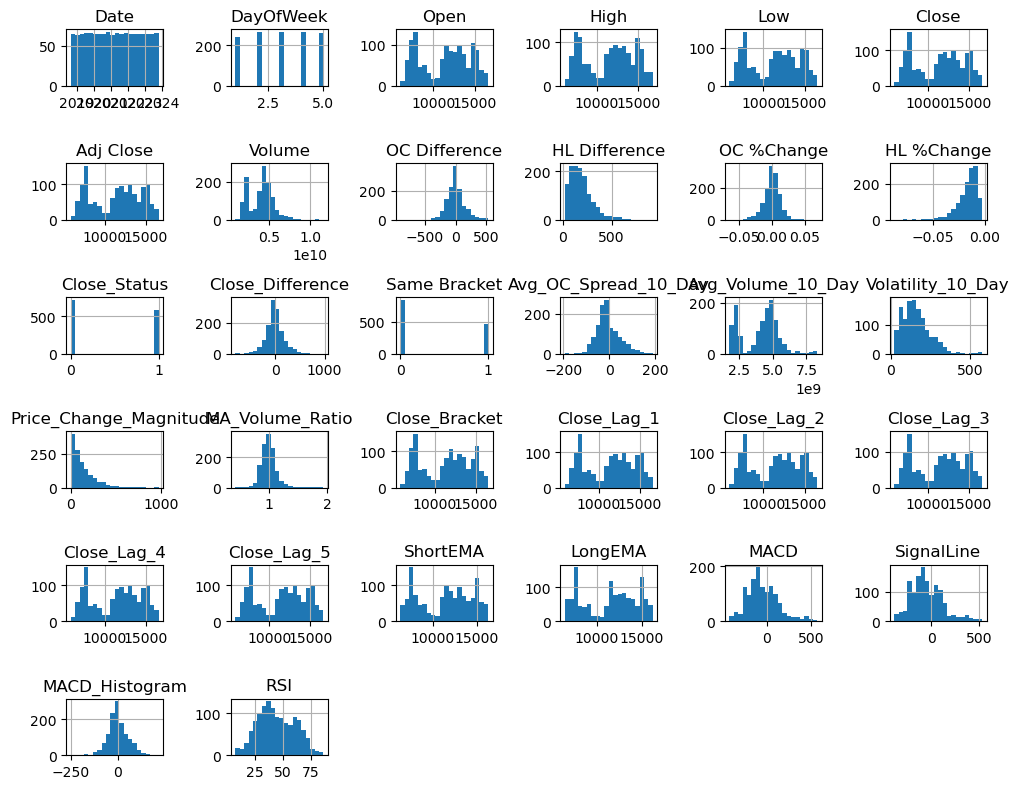

In [92]:
# Histograms and Density Plots
values.hist(bins=20, figsize=(10, 8))
plt.tight_layout()
plt.show()

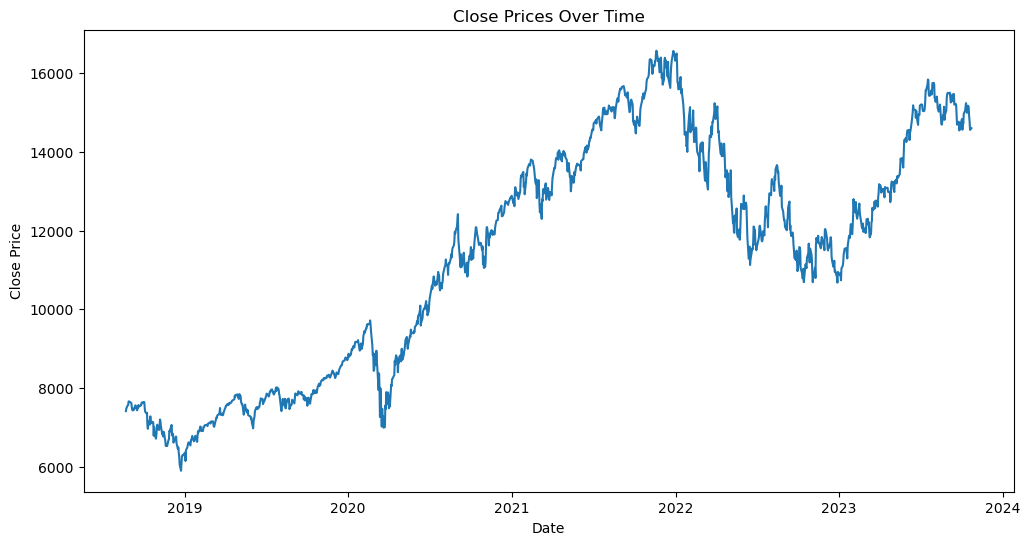

In [93]:
# Time Series Plot
plt.figure(figsize=(12, 6))
plt.plot(values['Date'], values['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Prices Over Time')
plt.show()

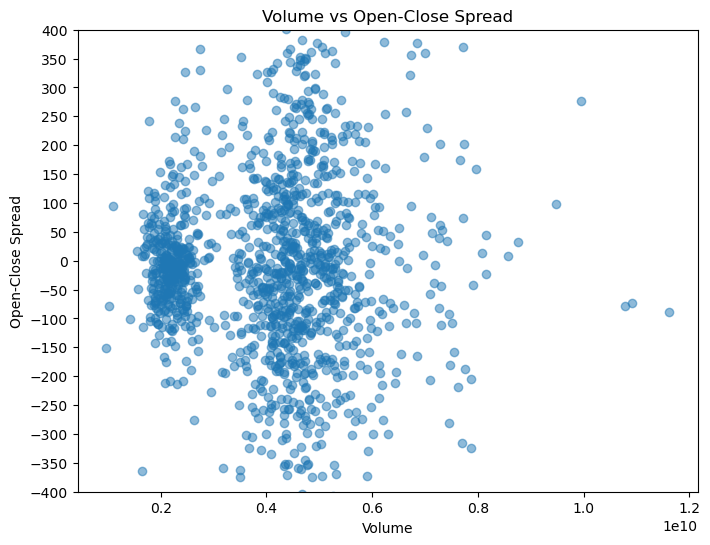

In [94]:
# Scatter Plot: Volume vs Open-Close Spread
plt.figure(figsize=(8, 6))
plt.scatter(values['Volume'], values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')
plt.ylim(-400, 400)
plt.yticks(range(-400, 401, 50))
plt.show()

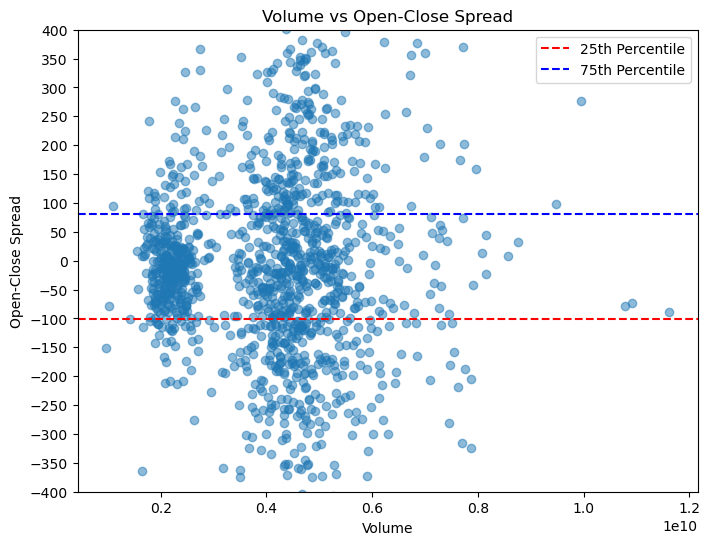

In [95]:
plt.figure(figsize=(8, 6))
plt.scatter(values['Volume'], values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')

# Set y-axis limits and tick spacing
plt.ylim(-400, 400)  # Adjust the y-axis limits as needed
plt.yticks(range(-400, 401, 50))  # Adjust the tick range and spacing as needed

# Add horizontal lines for 25th and 75th percentiles
plt.axhline(y=values['Close_Difference'].quantile(0.25), color='r', linestyle='--', label='25th Percentile')
plt.axhline(y=values['Close_Difference'].quantile(0.75), color='b', linestyle='--', label='75th Percentile')

# Add a legend
plt.legend()

plt.show()


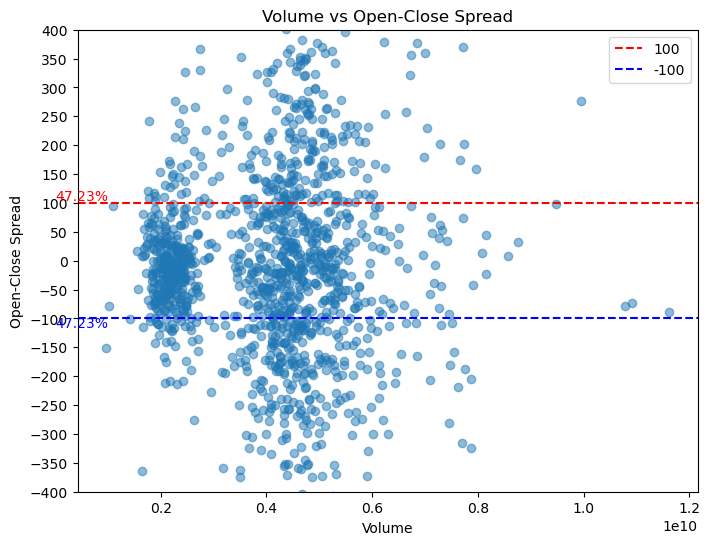

In [96]:
plt.figure(figsize=(8, 6))
plt.scatter(values['Volume'], values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')

# Set y-axis limits and tick spacing
plt.ylim(-400, 400)  # Adjust the y-axis limits as needed
plt.yticks(range(-400, 401, 50))  # Adjust the tick range and spacing as needed

# Add horizontal lines at 100 and -100
plt.axhline(y=100, color='r', linestyle='--', label='100')
plt.axhline(y=-100, color='b', linestyle='--', label='-100')

# Calculate percentage of rows between 100 and -100
percentage_between = 100 - ((values['Close_Difference'] > -100) & (values['Close_Difference'] < 100)).mean() * 100

# Annotate the percentage above the lines
plt.text(5, 105, f'{percentage_between:.2f}%', color='r', fontsize=10)
plt.text(5, -115, f'{percentage_between:.2f}%', color='b', fontsize=10)

# Add a legend
plt.legend()

plt.show()


### I wanted to dive deeper here to see how many days expereince an open close spread of 100 points in either direction and it being at half is not making me feel any better. SO I want to look at it for dates in the past 200 days

In [97]:
# Calculate the number of data points between -100 and 100
num_points_within_range = ((values['Close_Difference'] >= -100) & (values['Close_Difference'] <= 100)).sum()
total_rows = len(values)
percentage_within_range = (num_points_within_range / total_rows) * 100

print(f'Number of data points within the range (-100 to 100): {num_points_within_range}')
print(f'Percentage of total rows within the range: {percentage_within_range:.2f}%')
print('-'*80)

Number of data points within the range (-100 to 100): 686
Percentage of total rows within the range: 52.77%
--------------------------------------------------------------------------------


In [98]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')
total_rows = len(values)
# Calculate the number of data points between -200 and 200 within the entire DataFrame
num_points_within_range200 = ((values['Close_Difference'] >= -200) & (values['Close_Difference'] <= 200)).sum()
# Calculate the percentage
percentage_within_range200 = (num_points_within_range200 / total_rows) * 100

print(f'Number of data points within the range (-200 to 200): {num_points_within_range200}')
print(f'Percentage of total rows within the range: {percentage_within_range200:.2f}%')
print('-'*80)

Number of data points within the range (-200 to 200): 1009
Percentage of total rows within the range: 77.62%
--------------------------------------------------------------------------------


#### This is a much more exciting revelation and it will appear the same for the past 200 trading days as well. Meaning we can take a position

### Filtered out to examine only the past 200 Trading Days. The rest of the visualizations to follow are from the primary dataframe

In [99]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Filter the data for the past 200 trading days
past_200_days = values.tail(200)

# Calculate the number of data points between -100 and 100 within the filtered data
num_points_within_range = ((past_200_days['Close_Difference'] >= -100) & (past_200_days['Close_Difference'] <= 100)).sum()

# Calculate the total number of rows in the filtered data
total_rows = len(past_200_days)

# Calculate the percentage
percentage_within_range = (num_points_within_range / total_rows) * 100

print(f'Number of data points within the range (-100 to 100) in the past 200 trading days: {num_points_within_range}')
print(f'Percentage of total rows within the range: {percentage_within_range:.2f}%')
print('-'*80)

Number of data points within the range (-100 to 100) in the past 200 trading days: 91
Percentage of total rows within the range: 45.50%
--------------------------------------------------------------------------------


### Repeat of the above code but widening the range to -200,200

In [100]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Filter the data for the past 200 trading days
past_200_days = values.tail(200)

# Calculate the number of data points between -200 and 200 within the filtered data
num_points_within_range = ((past_200_days['Close_Difference'] >= -200) & (past_200_days['Close_Difference'] <= 200)).sum()

# Calculate the total number of rows in the filtered data
total_rows = len(past_200_days)

# Calculate the percentage
percentage_within_range = (num_points_within_range / total_rows) * 100

print(f'Number of data points within the range (-200 to 200) in the past 200 trading days: {num_points_within_range}')
print(f'Percentage of total rows within the range: {percentage_within_range:.2f}%')
print('-'*80)

Number of data points within the range (-200 to 200) in the past 200 trading days: 152
Percentage of total rows within the range: 76.00%
--------------------------------------------------------------------------------


#### Some quick inferences here the lower the trading volume the more like the spread will remain between 0-250

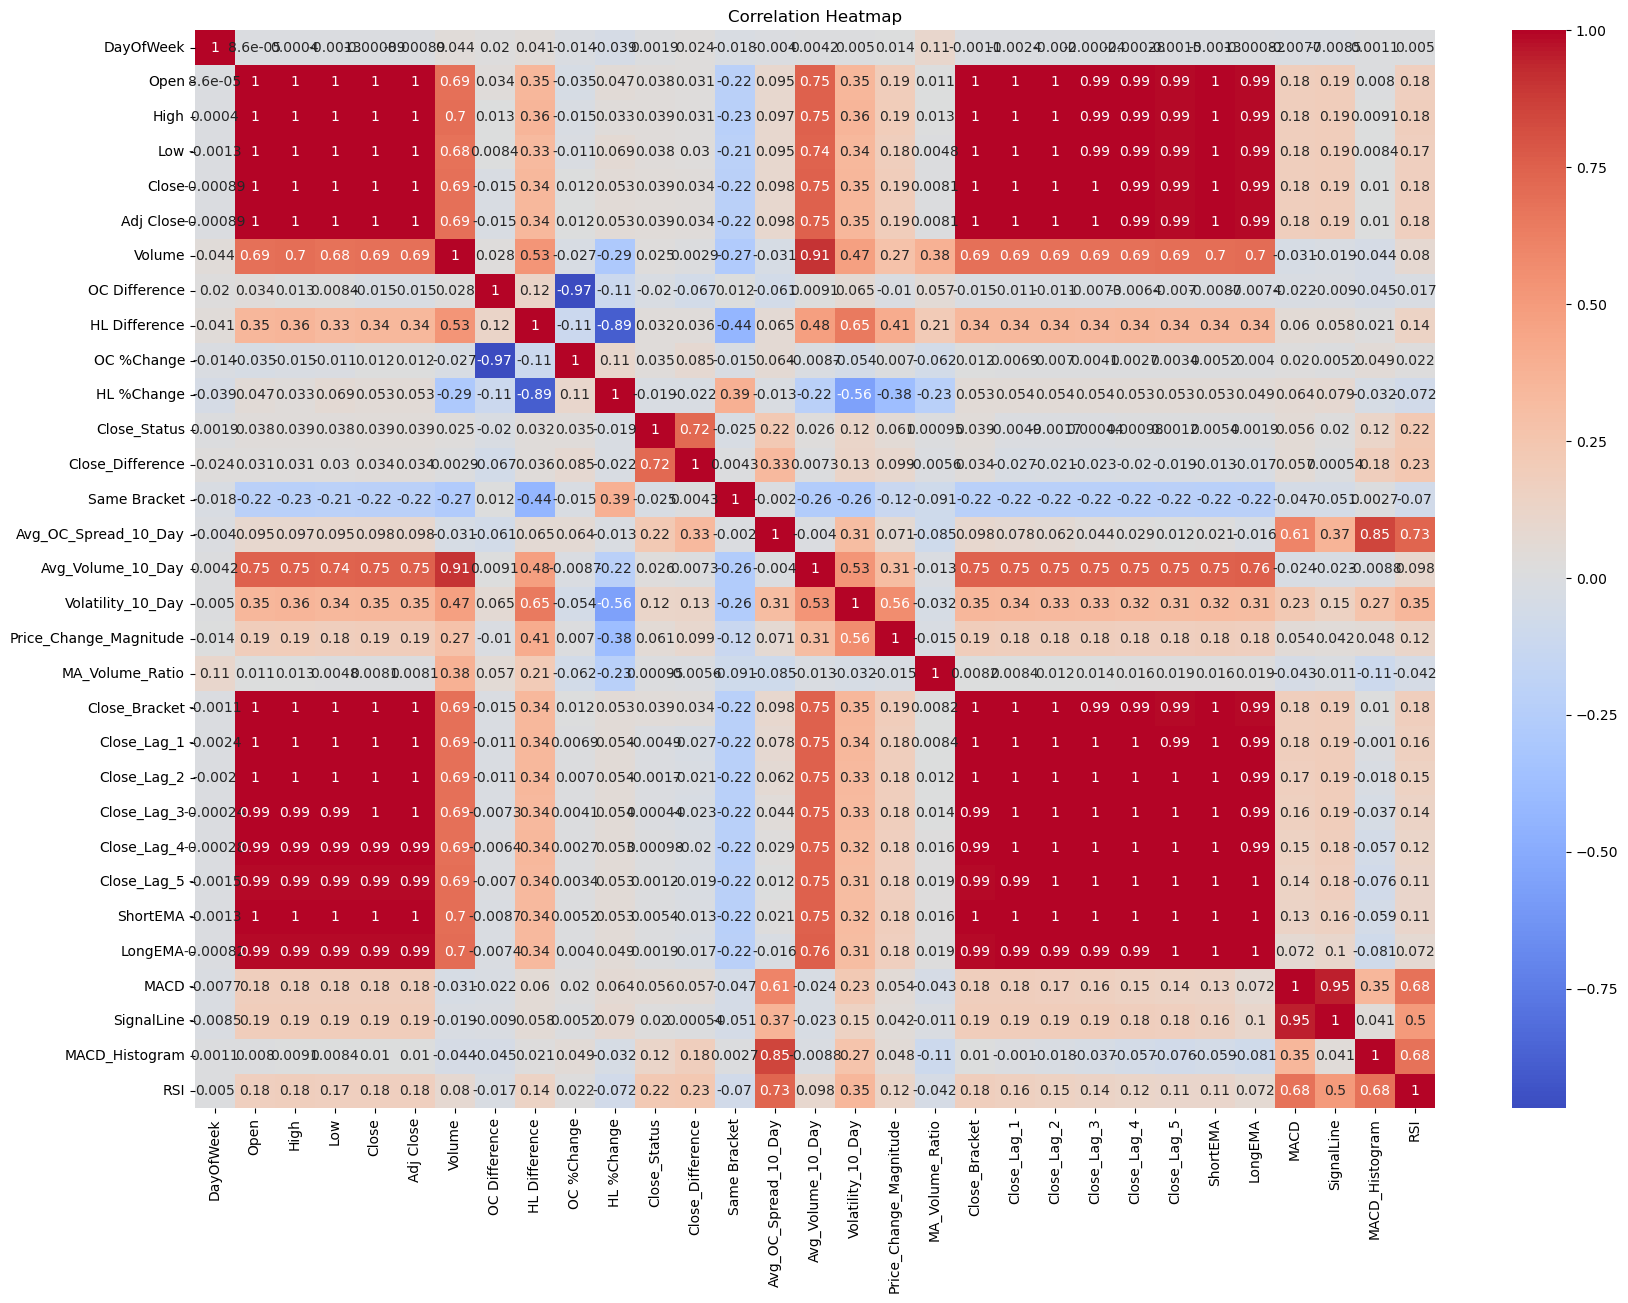

In [101]:
# Correlation Analysis
correlation_matrix = values.corr()
plt.figure(figsize=(20, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

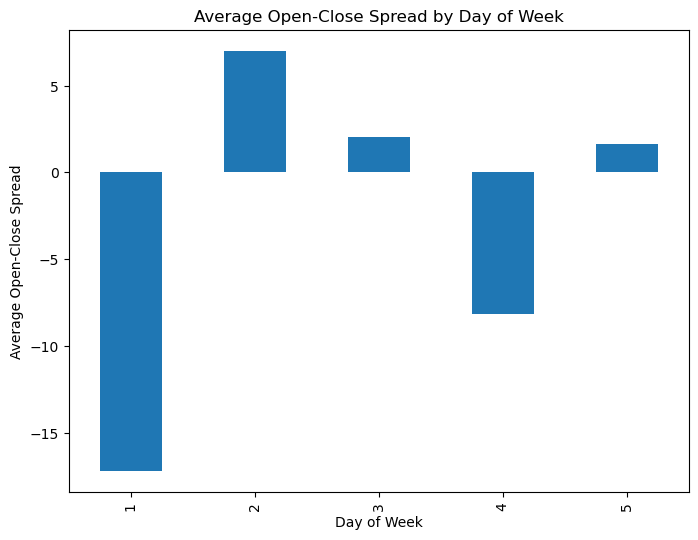

In [102]:
# Day-of-Week Analysis
avg_open_close_by_day = values.groupby('DayOfWeek')['OC Difference'].mean()
plt.figure(figsize=(8, 6))
avg_open_close_by_day.plot(kind='bar')
plt.xlabel('Day of Week')
plt.ylabel('Average Open-Close Spread')
plt.title('Average Open-Close Spread by Day of Week')
plt.show()

In [103]:
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Add a new column for the day of the week
values['DayOfWeek'] = values['Date'].dt.day_name()

# Calculate the averages for each trading day of the week
avg_close_spread_diff = values.groupby('DayOfWeek')['OC Difference'].mean()
avg_volume = values.groupby('DayOfWeek')['Volume'].mean()
avg_high_low_diff = values.groupby('DayOfWeek')['HL Difference'].mean()
avg_price_change_magnitude = values.groupby('DayOfWeek')['Price_Change_Magnitude'].mean()

# Display the results
print("Average Close Spread Difference by Day of the Week:")
print(avg_close_spread_diff)
print("\nAverage Volume by Day of the Week:")
print(avg_volume)
print("\nAverage High-Low Difference by Day of the Week:")
print(avg_high_low_diff)
print("\nAverage Price Change Magnitude by Day of the Week:")
print(avg_price_change_magnitude)
print('-'*80)

Average Close Spread Difference by Day of the Week:
DayOfWeek
Friday        1.632133
Monday      -17.195327
Thursday     -8.139665
Tuesday       7.005085
Wednesday     2.026409
Name: OC Difference, dtype: float64

Average Volume by Day of the Week:
DayOfWeek
Friday       4.153694e+09
Monday       3.938469e+09
Thursday     4.113182e+09
Tuesday      4.078985e+09
Wednesday    4.136792e+09
Name: Volume, dtype: float64

Average High-Low Difference by Day of the Week:
DayOfWeek
Friday       192.960496
Monday       183.394823
Thursday     201.757759
Tuesday      185.529170
Wednesday    194.137793
Name: HL Difference, dtype: float64

Average Price Change Magnitude by Day of the Week:
DayOfWeek
Friday       129.870042
Monday       124.525662
Thursday     130.154861
Tuesday      128.023860
Wednesday    141.139344
Name: Price_Change_Magnitude, dtype: float64
--------------------------------------------------------------------------------


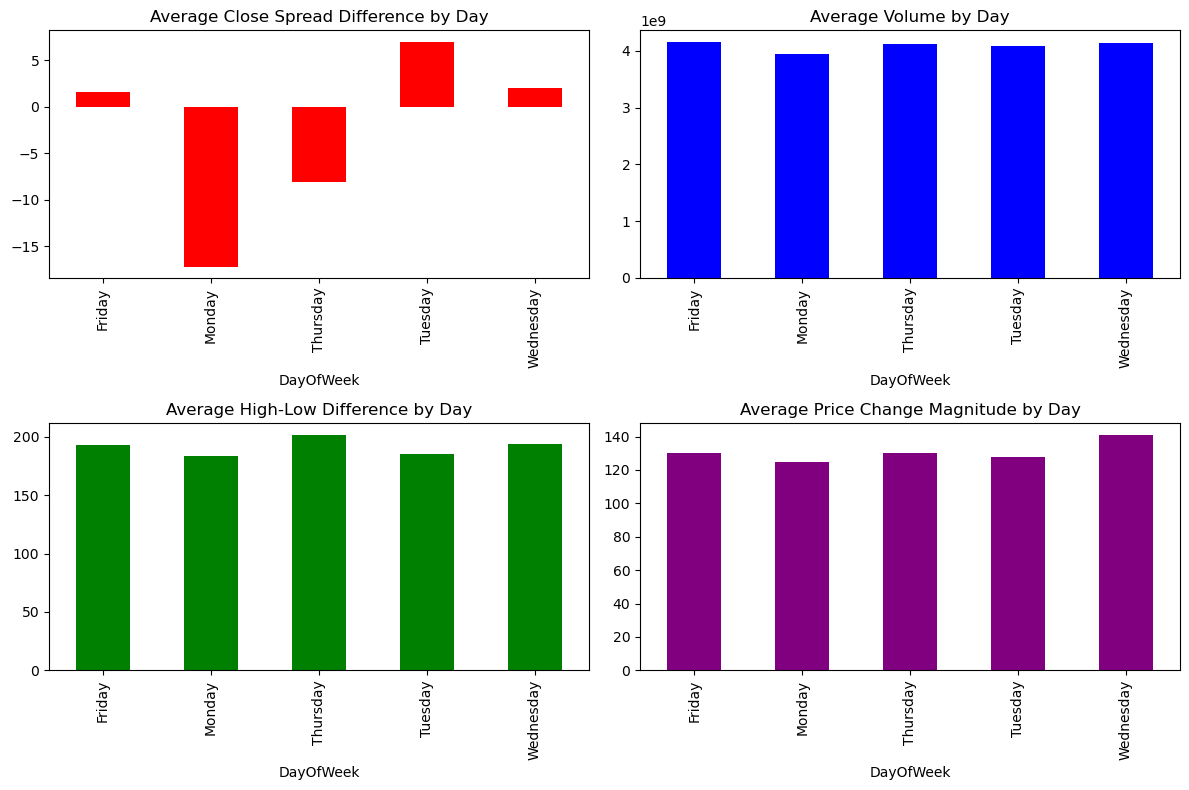

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'values' is your DataFrame
# Make sure the DataFrame is sorted by date in ascending order
values = values.sort_values('Date')

# Add a new column for the day of the week
values['DayOfWeek'] = values['Date'].dt.day_name()

# Calculate the averages for each trading day of the week
avg_close_spread_diff = values.groupby('DayOfWeek')['OC Difference'].mean()
avg_volume = values.groupby('DayOfWeek')['Volume'].mean()
avg_high_low_diff = values.groupby('DayOfWeek')['HL Difference'].mean()
avg_price_change_magnitude = values.groupby('DayOfWeek')['Price_Change_Magnitude'].mean()

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# Bar plots for each average
avg_close_spread_diff.plot(kind='bar', ax=axs[0, 0], color='r', title='Average Close Spread Difference by Day')
avg_volume.plot(kind='bar', ax=axs[0, 1], color='b', title='Average Volume by Day')
avg_high_low_diff.plot(kind='bar', ax=axs[1, 0], color='g', title='Average High-Low Difference by Day')
avg_price_change_magnitude.plot(kind='bar', ax=axs[1, 1], color='purple', title='Average Price Change Magnitude by Day')

# Adjust layout
plt.tight_layout()

plt.show()


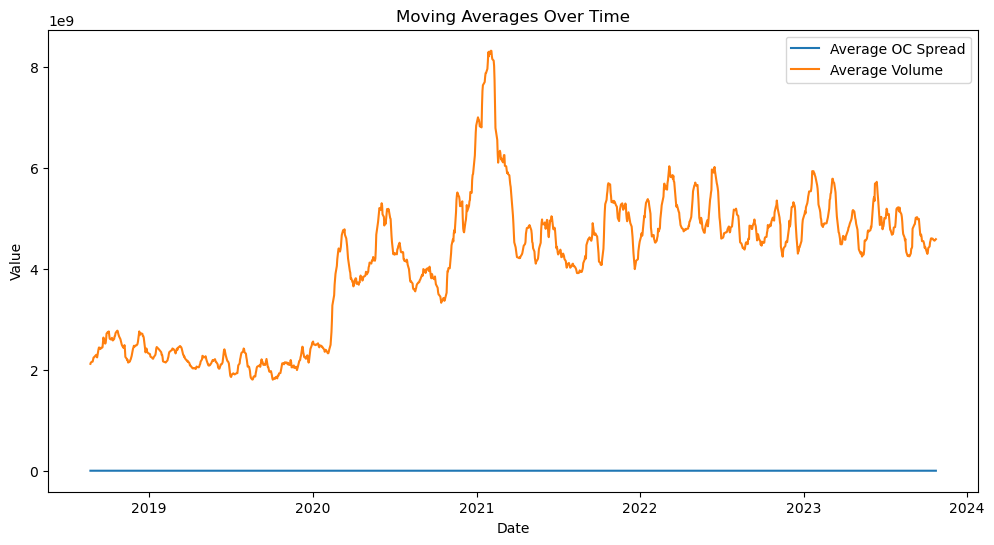

In [105]:
# Moving Averages Visualization
plt.figure(figsize=(12, 6))
plt.plot(values['Date'], values['Avg_OC_Spread_10_Day'], label='Average OC Spread')
plt.plot(values['Date'], values['Avg_Volume_10_Day'], label='Average Volume')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Averages Over Time')
plt.legend()
plt.show()

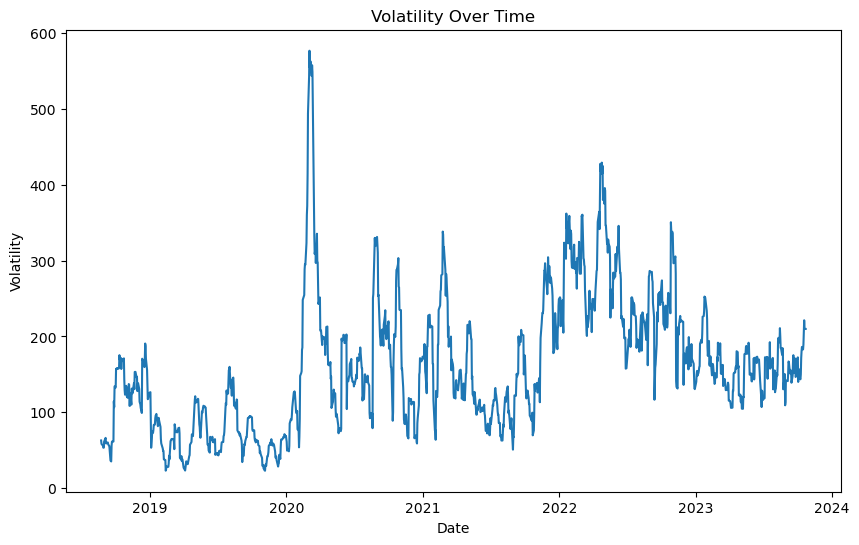

In [106]:
# Volatility Analysis
plt.figure(figsize=(10, 6))
plt.plot(values['Date'], values['Volatility_10_Day'])
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.title('Volatility Over Time')
plt.show()

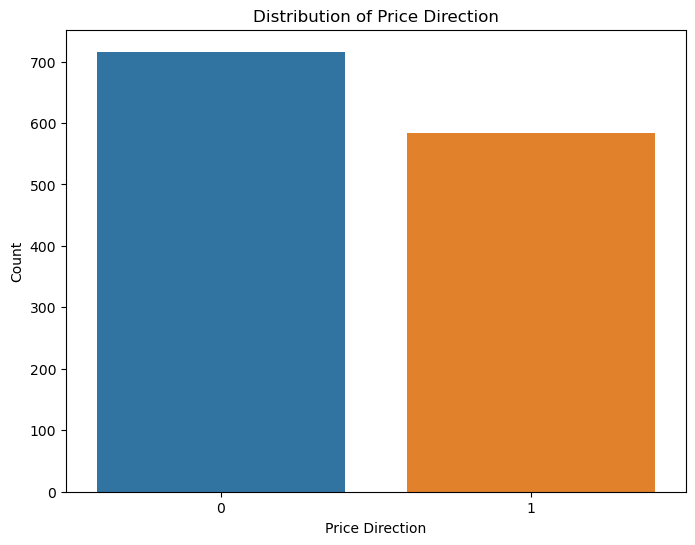

In [107]:
# Price Direction Analysis
plt.figure(figsize=(8, 6))
sns.countplot(data=values, x='Price_Direction')
plt.xlabel('Price Direction')
plt.ylabel('Count')
plt.title('Distribution of Price Direction')
plt.show()

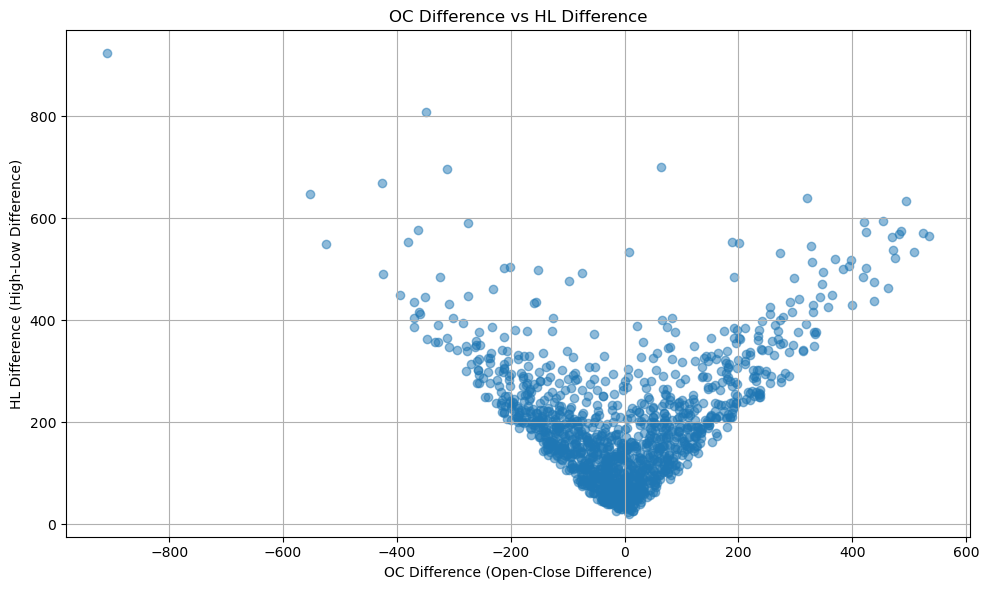

In [108]:
values = values.sort_values('Date')

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(values['OC Difference'], values['HL Difference'], alpha=0.5)
plt.xlabel('OC Difference (Open-Close Difference)')
plt.ylabel('HL Difference (High-Low Difference)')
plt.title('OC Difference vs HL Difference')
plt.grid(True)
plt.tight_layout()

plt.show()

---

Feature Importance as **Same Bracket** as the target variable

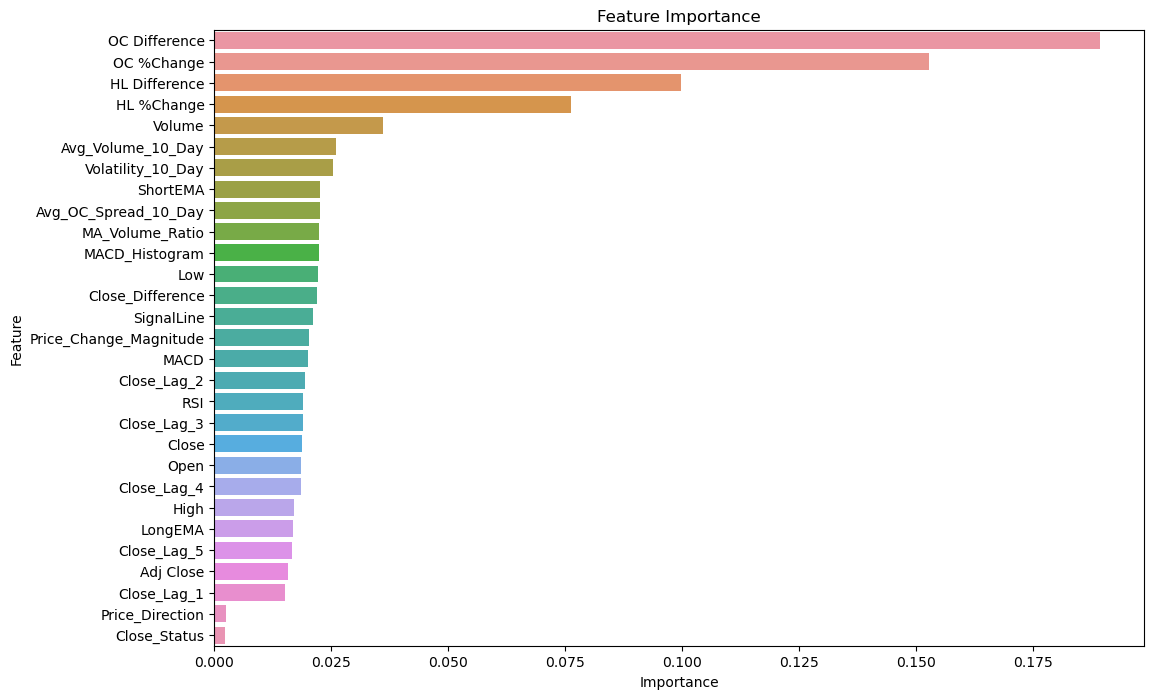

In [109]:
from sklearn.ensemble import RandomForestClassifier
X = values.drop(columns=['Same Bracket', 'Date','Close_Bracket','DayOfWeek'])
y = values['Same Bracket']

rf = RandomForestClassifier()
rf.fit(X, y)

importance = rf.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance}).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12,8))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()


Feature Importance as **Close Price** as target variable

In [110]:
X = values.drop(columns=['Same Bracket', 'Date','Close','Adj Close','Close_Bracket','DayOfWeek'])
y = values['Close']

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X, y)

# Extracting feature importances
feature_importances = rf_regressor.feature_importances_

# Mapping feature importances to feature names and sorting them
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(features_df)
print('-'*100)

                   Feature    Importance
1                     High  4.273017e-01
2                      Low  3.886611e-01
16             Close_Lag_1  5.600863e-02
21                ShortEMA  4.720687e-02
22                 LongEMA  3.927874e-02
0                     Open  2.526907e-02
19             Close_Lag_4  7.904220e-03
18             Close_Lag_3  7.800574e-03
4            OC Difference  1.106969e-04
17             Close_Lag_2  1.098987e-04
6               OC %Change  1.044486e-04
23                    MACD  3.780014e-05
20             Close_Lag_5  2.622026e-05
10    Avg_OC_Spread_10_Day  2.098899e-05
25          MACD_Histogram  1.717822e-05
9         Close_Difference  1.702000e-05
15         MA_Volume_Ratio  1.544556e-05
13  Price_Change_Magnitude  1.471061e-05
24              SignalLine  1.452039e-05
7               HL %Change  1.404429e-05
3                   Volume  1.394584e-05
5            HL Difference  1.359156e-05
26                     RSI  1.238209e-05
12       Volatil

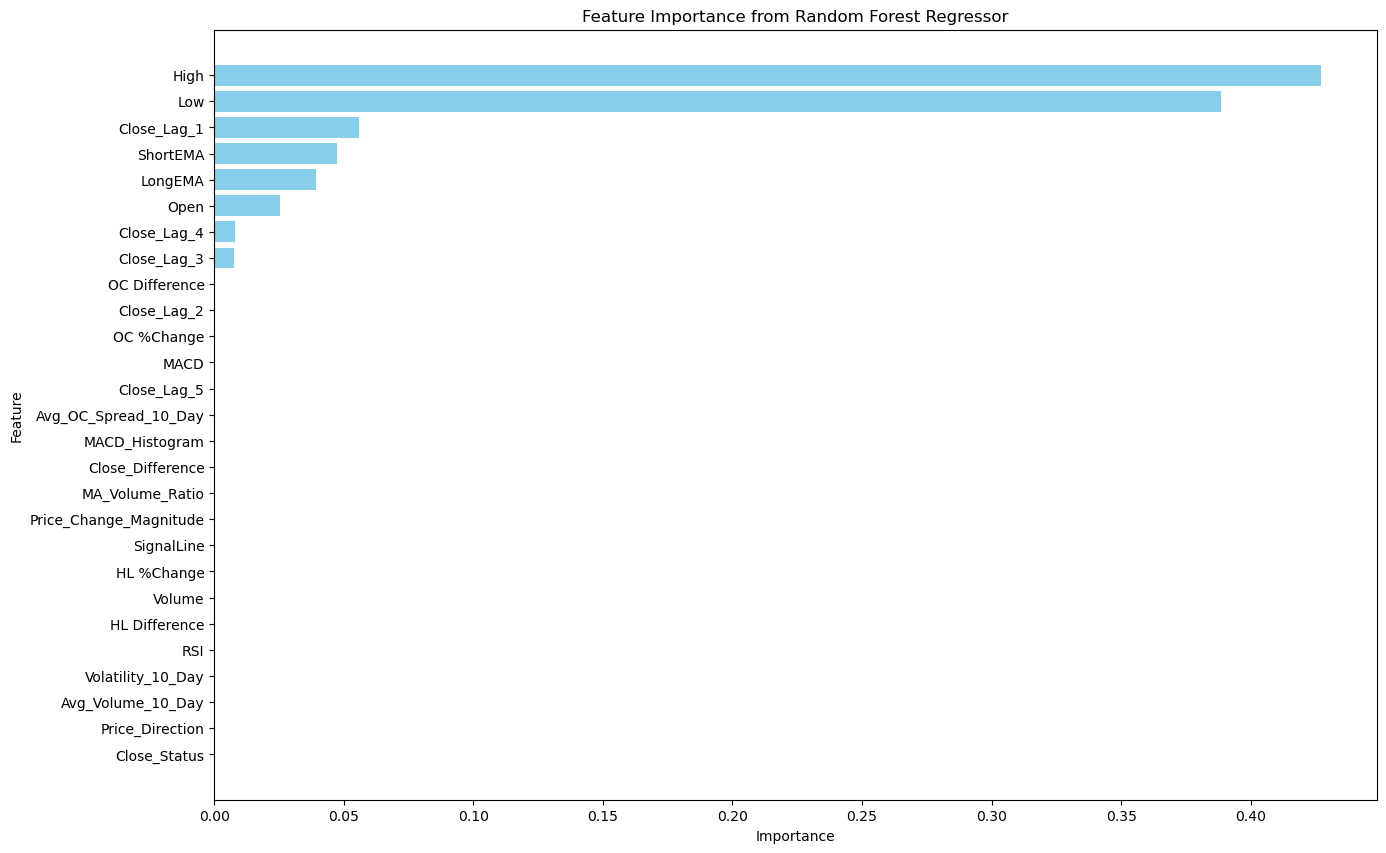

In [111]:
plt.figure(figsize=(15, 10))
plt.barh(features_df['Feature'], features_df['Importance'], align='center', color='skyblue')
plt.gca().invert_yaxis()  # This will order the features from most to least important at the top
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest Regressor')
plt.show()

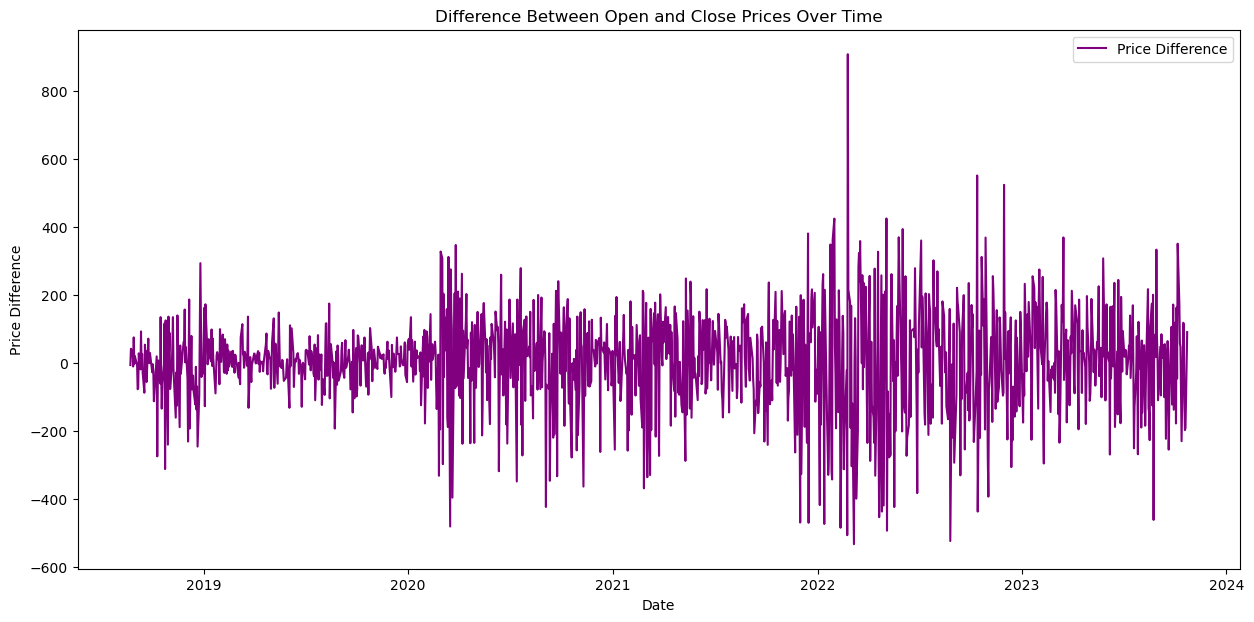

In [127]:
import matplotlib.pyplot as plt

# Assuming 'values' is your DataFrame and it contains 'Date', 'Open', and 'Close' columns.
# Calculating the difference between 'Close' and 'Open' prices
values['Price_Difference'] = values['Close'] - values['Open']

# Plotting the difference
plt.figure(figsize=(15, 7))
plt.plot(values['Date'], values['Price_Difference'], label='Price Difference', color='purple')

plt.title('Difference Between Open and Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()


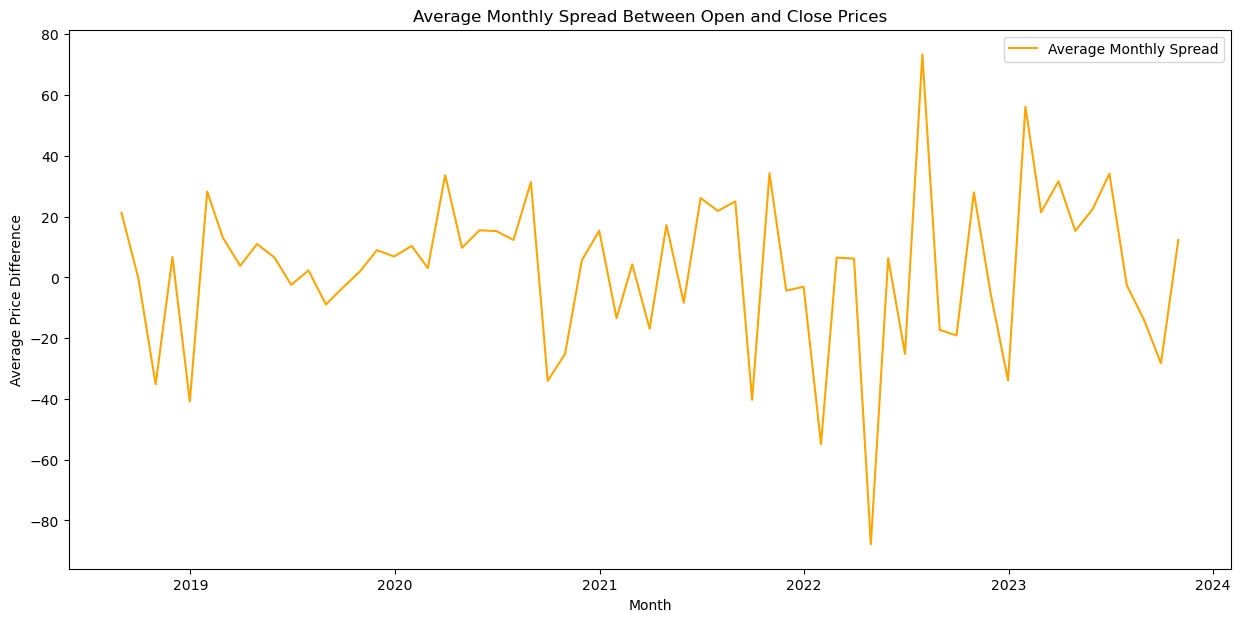

In [128]:
# Calculating the difference between 'Close' and 'Open' prices
values['Price_Difference'] = values['Close'] - values['Open']

# Setting the 'Date' as the index
values.set_index('Date', inplace=True)

# Grouping by month and calculating the mean of the 'Price_Difference'
monthly_spread = values['Price_Difference'].resample('M').mean()

# Resetting the index to get 'Date' back as a column
monthly_spread = monthly_spread.reset_index()

# Plotting the average monthly spread
plt.figure(figsize=(15, 7))
plt.plot(monthly_spread['Date'], monthly_spread['Price_Difference'], label='Average Monthly Spread', color='orange')

plt.title('Average Monthly Spread Between Open and Close Prices')
plt.xlabel('Month')
plt.ylabel('Average Price Difference')
plt.legend()
plt.show()


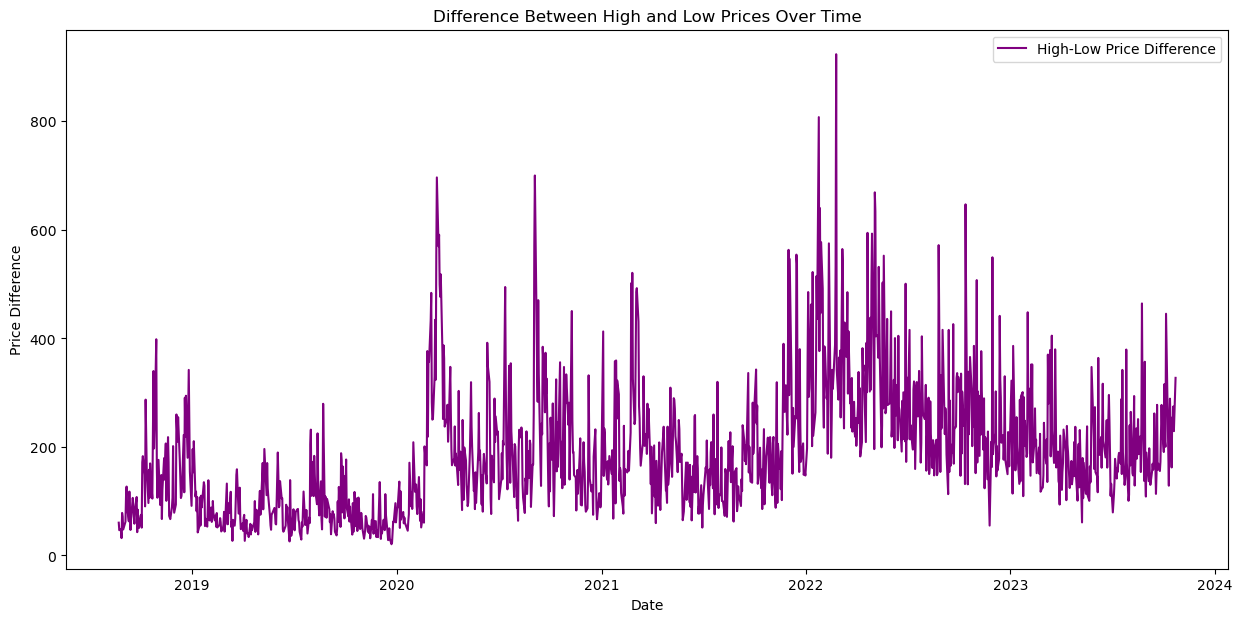

In [132]:
values['HL_Difference'] = values['High'] - values['Low']
plt.figure(figsize=(15, 7))
plt.plot(values.index, values['HL_Difference'], label='High-Low Price Difference', color='purple')
plt.title('Difference Between High and Low Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()


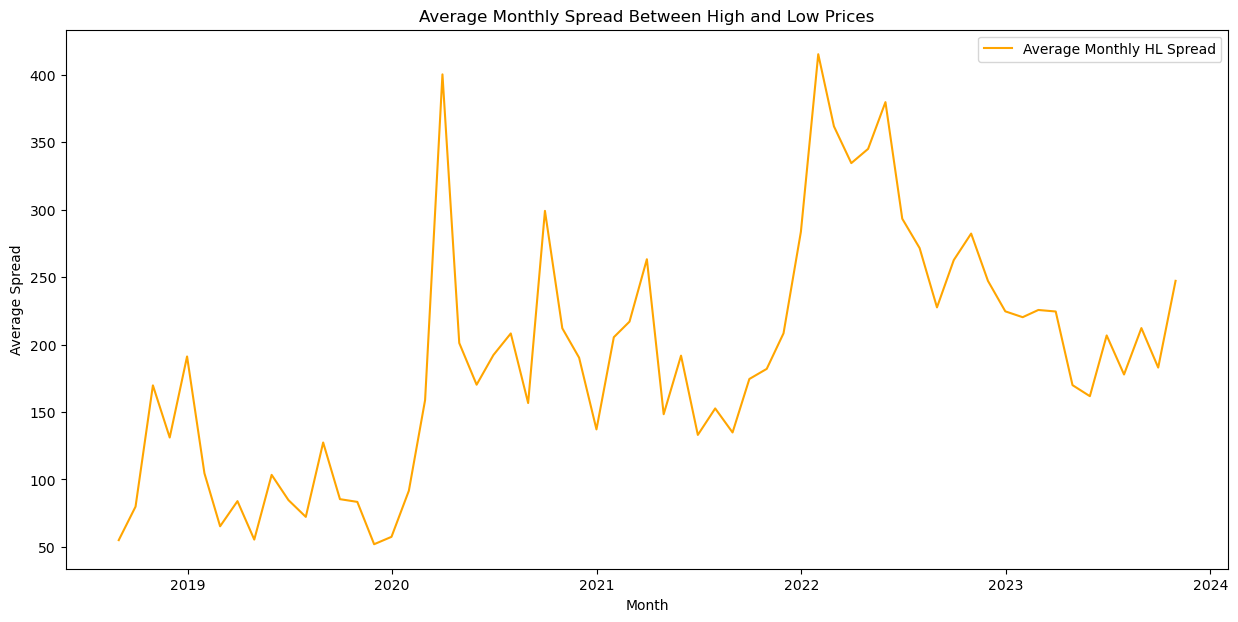

In [133]:
# Calculate monthly average spread
monthly_avg_hl_spread = values['HL_Difference'].resample('M').mean()

# Reset index
monthly_avg_hl_spread = monthly_avg_hl_spread.reset_index()

plt.figure(figsize=(15, 7))
plt.plot(monthly_avg_hl_spread['Date'], monthly_avg_hl_spread['HL_Difference'], label='Average Monthly HL Spread', color='orange')
plt.title('Average Monthly Spread Between High and Low Prices')
plt.xlabel('Month')
plt.ylabel('Average Spread')
plt.legend()
plt.show()


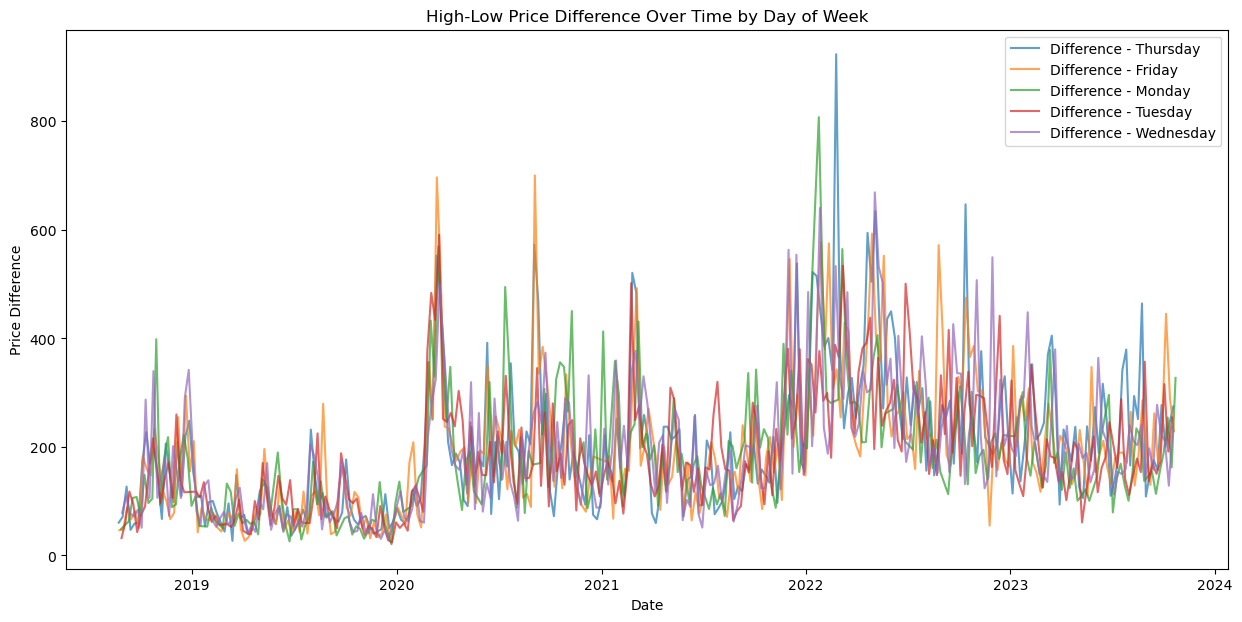

In [135]:
plt.figure(figsize=(15, 7))
for day in days_of_week:
    day_values = values[values['DayOfWeek'] == day]
    plt.plot(day_values.index, day_values['High'] - day_values['Low'], label=f'Difference - {day}', alpha=0.7)
plt.title('High-Low Price Difference Over Time by Day of Week')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()


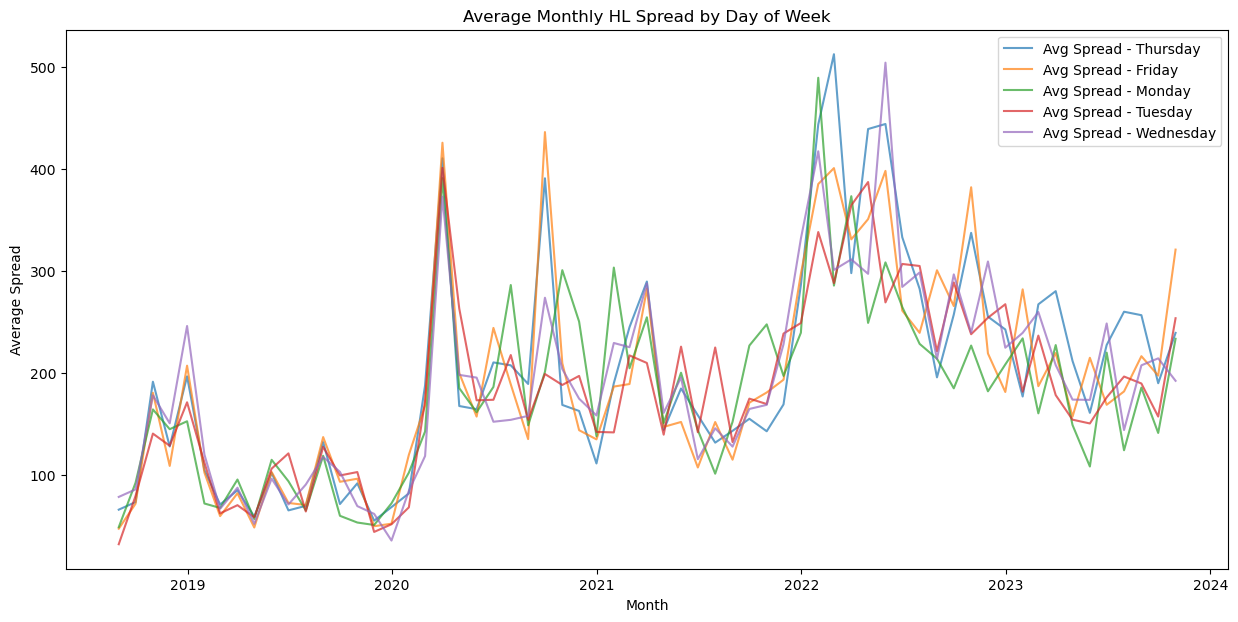

In [136]:
plt.figure(figsize=(15, 7))
for day in days_of_week:
    day_values = values[values['DayOfWeek'] == day]
    monthly_avg_hl_spread = day_values['HL_Difference'].resample('M').mean().reset_index()
    plt.plot(monthly_avg_hl_spread['Date'], monthly_avg_hl_spread['HL_Difference'], label=f'Avg Spread - {day}', alpha=0.7)
plt.title('Average Monthly HL Spread by Day of Week')
plt.xlabel('Month')
plt.ylabel('Average Spread')
plt.legend()
plt.show()


In [137]:
# Group the data by 'DayOfWeek' and calculate the mean 'HL_Difference' for each group
average_spreads_by_day = values.groupby('DayOfWeek')['HL_Difference'].mean()

# Sort the averages to find the smallest spread
sorted_average_spreads = average_spreads_by_day.sort_values()

# The day with the smallest average spread
smallest_spread_day = sorted_average_spreads.index[0]
smallest_spread_value = sorted_average_spreads.iloc[0]

print(f"The day with the smallest average spread is {smallest_spread_day} with an average spread of {smallest_spread_value}")


The day with the smallest average spread is Monday with an average spread of 183.3948226213992


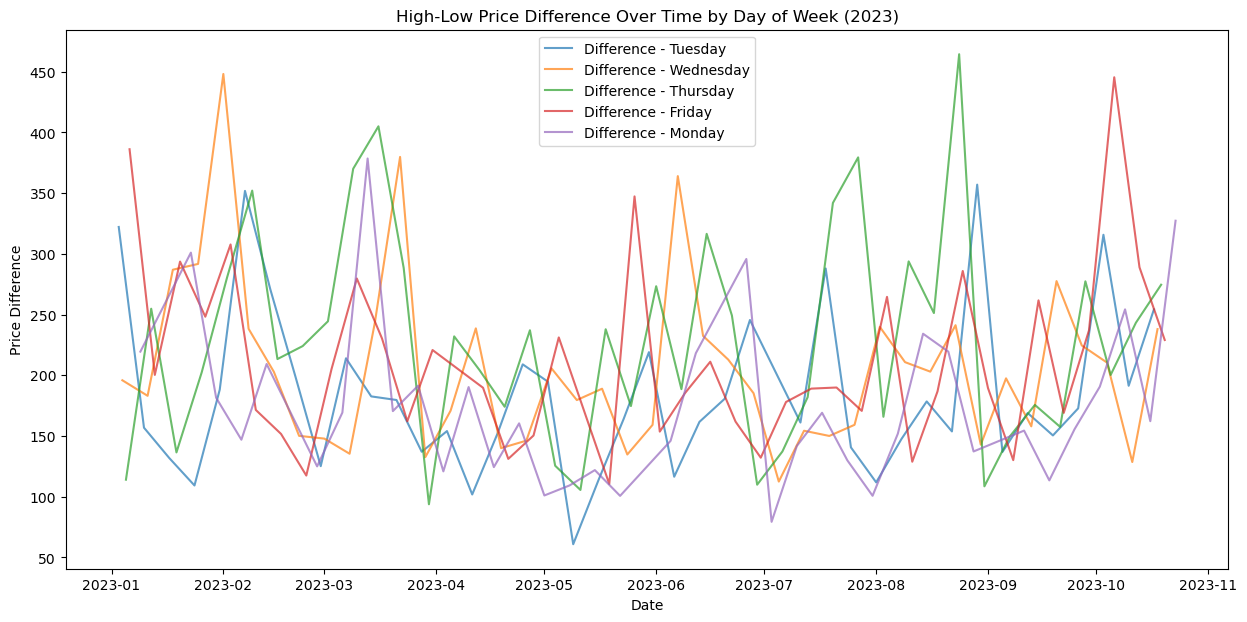

In [138]:
# Filter the DataFrame for the year 2023
values_2023 = values.loc['2023']

# Plot the high-low price difference for each day of the week in 2023
plt.figure(figsize=(15, 7))
days_of_week = values_2023['DayOfWeek'].unique()
for day in days_of_week:
    day_values = values_2023[values_2023['DayOfWeek'] == day]
    plt.plot(day_values.index, day_values['High'] - day_values['Low'], label=f'Difference - {day}', alpha=0.7)

plt.title('High-Low Price Difference Over Time by Day of Week (2023)')
plt.xlabel('Date')
plt.ylabel('Price Difference')
plt.legend()
plt.show()


/var/folders/n_/367n_sc56lj0q1ddbd82d5qw0000gn/T/ipykernel_74070/122562964.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  values_2023['Week_Number'] = values_2023.index.isocalendar().week


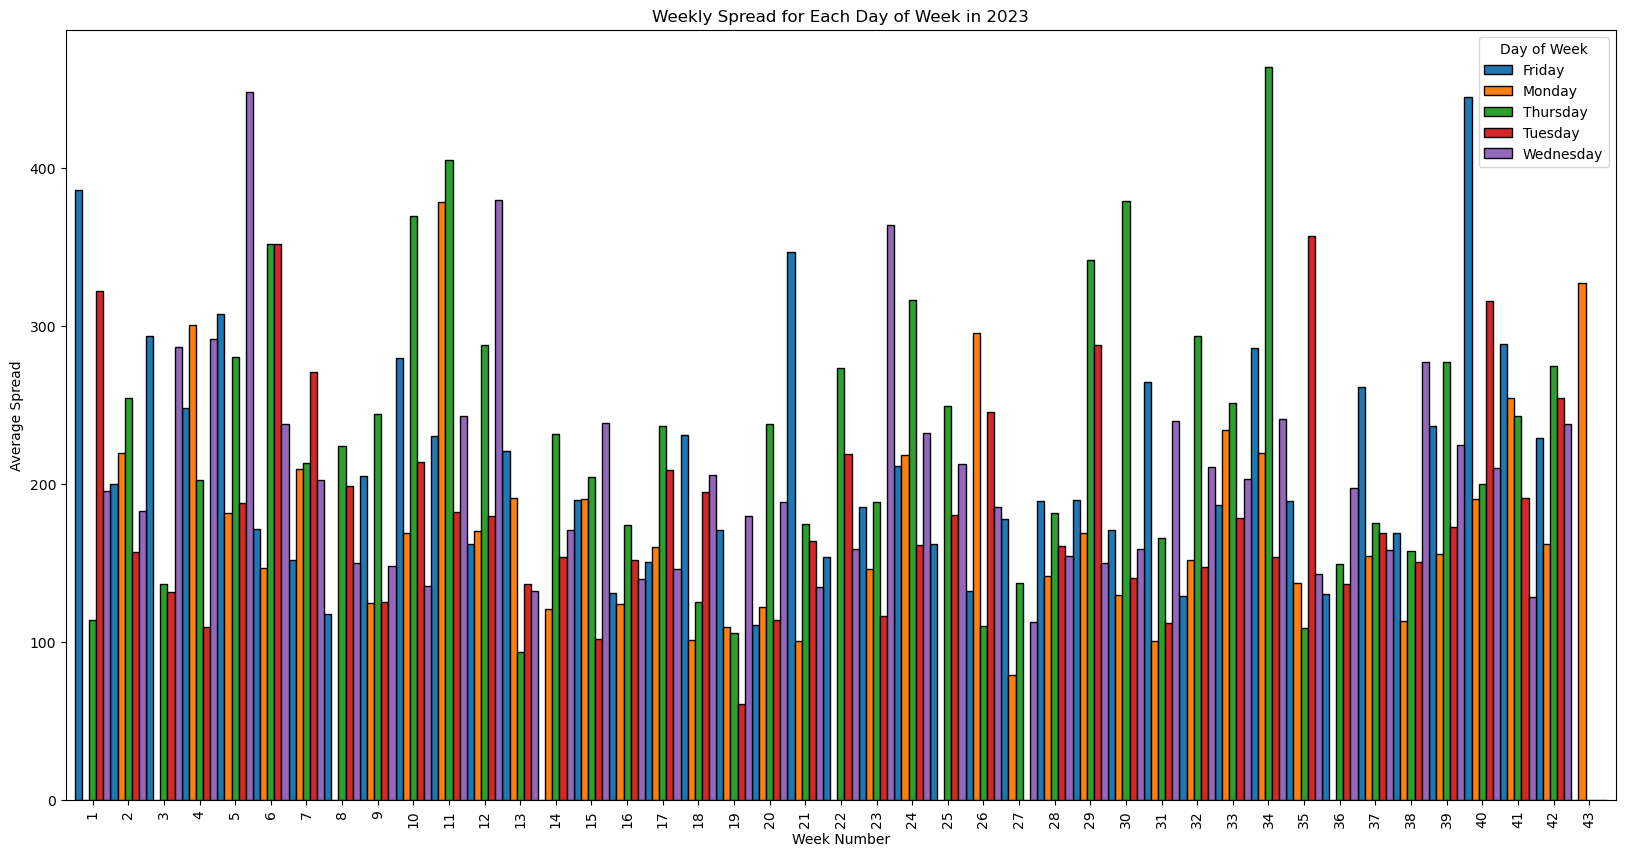

In [139]:
# Filter the DataFrame for the year 2023
values_2023 = values.loc['2023']

# Calculate the week number for each date
values_2023['Week_Number'] = values_2023.index.isocalendar().week

# Group by week and day of the week and calculate the mean spread for each group
weekly_spread = values_2023.groupby(['Week_Number', 'DayOfWeek'])['HL_Difference'].mean().unstack()

# Plotting
weekly_spread.plot(kind='bar', figsize=(20, 10), width=1, edgecolor='black')
plt.title('Weekly Spread for Each Day of Week in 2023')
plt.xlabel('Week Number')
plt.ylabel('Average Spread')
plt.legend(title='Day of Week')
plt.show()


In [142]:
# Filter the DataFrame for the year 2023 and avoid the SettingWithCopyWarning by explicitly copying the slice
values_2023 = values['2023'].copy()

# Calculate the week number for each date
values_2023['Week_Number'] = values_2023.index.isocalendar().week

# Group by week number and day of the week and calculate the mean spread for each group
weekly_spread = values_2023.groupby(['Week_Number', 'DayOfWeek'])['HL_Difference'].mean()

# Reset index so 'Week_Number' and 'DayOfWeek' become columns
weekly_spread = weekly_spread.reset_index()

# Find the day with the highest spread for each week
idx = weekly_spread.groupby('Week_Number')['HL_Difference'].idxmax()
weekly_max_spreads = weekly_spread.loc[idx]

# Count the number of times each day has the highest spread
day_counts = weekly_max_spreads['DayOfWeek'].value_counts()

print(day_counts)


Thursday     20
Friday       11
Wednesday     7
Monday        3
Tuesday       2
Name: DayOfWeek, dtype: int64


/var/folders/n_/367n_sc56lj0q1ddbd82d5qw0000gn/T/ipykernel_74070/1541293215.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  values_2023 = values['2023'].copy()


In [143]:
# Calculate the average spread for Mondays
monday_spread_avg = values_2023[values_2023['DayOfWeek'] == 'Monday']['HL_Difference'].mean()

# Calculate the average spread for Tuesdays
tuesday_spread_avg = values_2023[values_2023['DayOfWeek'] == 'Tuesday']['HL_Difference'].mean()

print(f"Average spread on Mondays: {monday_spread_avg}")
print(f"Average spread on Tuesdays: {tuesday_spread_avg}")


Average spread on Mondays: 175.8107580540542
Average spread on Tuesdays: 184.68430817073164


## Addressing Scaling
### Algorithms Sensitive to Feature Scale:

        Distance-based algorithms like K-Nearest Neighbors (KNN) and Support Vector Machines (SVM) are sensitive to the scale of the data. If one feature has a much broader range than another, it can dominate the distance calculations.
        Gradient Descent-based algorithms like neural networks, linear regression with gradient descent, and logistic regression are faster to train when features are on a similar scale.
        Regularization techniques like LASSO and Ridge regression can be sensitive to feature scales because they apply penalties to feature coefficients. Unscaled features can result in inconsistent penalties.
### Algorithms Not Sensitive to Feature Scale:
        
        Tree-based algorithms like Decision Trees, Random Forests, and Gradient Boosted Trees don't require feature scaling. These models are splitting the data based on feature thresholds, not based on feature magnitudes.

### Potential Benefits of Scaling:

        Improved Convergence: Algorithms that rely on optimization (like gradient descent) can converge faster when features are on a similar scale.
        Better Model Performance: Some algorithms can perform better when features are scaled.
        Improved Interpretability: Standardized coefficients in linear models become more interpretable. A larger coefficient magnitude can then be interpreted as a feature having a stronger effect.

### Types of Scaling:
        Min-Max Scaling: Scales features to be within a specified range, usually [0, 1].
        Standard Scaling (Z-score normalization): Scales features to have a mean of 0 and a standard deviation of 1.
        Robust Scaling: Uses median and interquartile range to scale features, making it robust to outliers.

# **NOTE**

At this point in the EDA I came to a crossroads for how to proceed. My two options were as follows:
1. Attempt to predict the closing prices and then use the difference between the open price and prediction price to be my close bracket of investment 
2. Attempt to predict whether or not the close value would be in the same bracket as the open value and then make the invesment based off the yes or now answer. Would asses the stddev to invest in further brackets

I did a analysis of both methods below.

### Regression Approach (Predicting the Close Price):
* Pros:
    * Flexibility: By predicting a continuous value, you're not limited to predefined categories. This flexibility can be particularly beneficial if the market sees unexpected movements.
    * Post-processing: After predicting the close price, you can easily map it to a bracket or calculate the difference between the predicted and actual close prices to assess the model's performance.
    * Detailed Insight: You get an exact prediction of the closing price, which can provide insights beyond just the bracket it falls into.
* Cons:
    * Potential Complexity: Predicting exact values can be more challenging due to the myriad of factors influencing stock prices.
    * Error Interpretation: A small prediction error might be inconsequential if it doesn't change the bracket prediction but can still affect regression metrics like RMSE.

### Classification Approach (Predicting the Bracket):
* Pros:
    * Direct Objective Alignment: Since your investment goal is based on predicting brackets, this approach directly aligns with that.
    * Clear Metrics: Classification offers clear metrics like accuracy, precision, recall, and F1 score. An accuracy of 90%, for instance, directly translates to being correct 90% of the time.
    * Potential Simplification: Stock price movements are inherently noisy. By converting them into categories, you might filter out some of this noise.
* Cons:
    * Loss of Granularity: By categorizing prices into brackets, you lose some information. For example, a closing price of $14501 and 14599 both fall into the same bracket, but they represent different market behaviors.
    * Dynamic Bracket Assignment: If the stock price undergoes significant changes, you may need to redefine your brackets, making the task tricky.

#### After weighing the two options Ive learned two things:
* We have to test out both as one doesnt offer a significant amount of added value to disregard the other
* We need more intraday data to help us come to a conclusion on the best approach

# Conclusion (Data Cleaning and EDA)

* Simply put I need much more features, specifically more intraday features. However before moving forward with that I want to understand how well my models will perform with the feature set I have already provided
* Still uncertainty if we will achieve and stick to the problem statement at hand. Classification vs Regression is still something I am thinking about and Im hoping how the models perform will help lean one way or another which will help me understand just how mant more features I need to get
* Given the large clusters of close prices within a 200 point close difference in either direction I understand now that the current price of the open, and early market action will dictate the purchasing price of these options. the brackets will always be split by a 100 points but their values will be skewed heavly one way or another depending on market action and open.
    * For example is the Open is 15314 and the market is heading downwards, the same bracket price would actually be a lot more expensive then the bracket below at 15200-15300. Additionally at that same price if the market heads upwards. the price two brackets above 15400-15500 might actually be more expensive then the price right below at 15200-15300. If pretty difficult to build a model that will be able to train and react both in real time at least to my current knowledge but we will learn and figure it out. Eventually we will connect through kalshi api and build a real time data stream in AWS to help with training modeling and investing.

In [225]:
#values.to_csv('../data/kalshi_features_v1.csv', index=False)

# Modeling

### Here we are just modeling to predict close price in which we will compare its actual close price and get the spread. In Modeling Pt2. we will look at failure/success if the close landing in the same bracket as the open

## Linear Regression Model

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [145]:
values.tail()

,DayOfWeek,Open,High,Low,Close,Adj Close,Volume,OC Difference,HL Difference,OC %Change,...,Close_Lag_4,Close_Lag_5,ShortEMA,LongEMA,MACD,SignalLine,MACD_Histogram,RSI,Price_Difference,HL_Difference
Date,,,,,,,,,,,,,,,,,,,,,
2023-10-17,Tuesday,15009.259766,15187.059570,14932.769531,15122.009766,15122.009766,4417640000,-112.750000,254.290039,0.007512,...,14604.849609,14745.860352,14756.570279,14845.489052,-88.918774,-147.780740,58.861967,49.322010,112.750000,254.290039
2023-10-18,Wednesday,15022.280273,15103.870117,14865.809570,14909.259766,14909.259766,4617140000,113.020507,238.060547,-0.007524,...,14745.860352,14381.639648,14690.126736,14823.367395,-133.240660,-162.496232,29.255572,41.792372,-113.020507,238.060547
2023-10-19,Thursday,14981.129883,15023.910156,14749.299805,14783.129883,14783.129883,5014790000,198.000000,274.610351,-0.013217,...,14381.639648,14109.570313,14650.284367,14816.496006,-166.211639,-169.810125,3.598486,38.205042,-198.000000,274.610351
2023-10-20,Friday,14752.589844,14781.219727,14552.120117,14560.879883,14560.879883,4622840000,191.709961,229.099610,-0.012995,...,14109.570313,14180.419922,14626.130636,14819.165296,-193.034659,-170.709746,-22.324913,35.023629,-191.709961,229.099610
2023-10-23,Monday,14514.110352,14746.370117,14419.059570,14604.849609,14604.849609,4669060000,-90.739257,327.310547,0.006252,...,14180.419922,14335.509766,14637.994410,14839.828129,-201.833719,-165.128518,-36.705201,35.759337,90.739257,327.310547


In [146]:
# Split data into features (X) and target variable (y)
X = values[['Open','High','Low','Volume','Avg_OC_Spread_10_Day','Avg_Volume_10_Day','MA_Volume_Ratio']]
y = values['Close']

In [147]:
# Split data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [148]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

# Now train your model using X_train_scaled and y_train


In [149]:
# Create and train a linear regression model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

LinearRegression()

In [150]:
# Make predictions
y_pred = lr.predict(X_test_scaled)

In [151]:
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 3275.6038890879495


## XGB Regressor Model

#### So Safe to say that linear regression and MSE score is useless here. Next we will be trying XGBoost

In [121]:
from xgboost import XGBRegressor
# Load your dataset
# Assuming 'values' is your DataFrame

# Load your dataset
# Assuming 'values' is your DataFrame

# Split data into features (X) and target variable (y)
X = values.drop(['Date', 'Close','DayOfWeek'], axis=1)  # Exclude 'Date' and 'Close' and 'DayOfWeek'
#X = values[['Open','High','Low','Volume','Avg_OC_Spread_10_Day','Avg_Volume_10_Day','MA_Volume_Ratio','HL Difference']]
y = values['Close']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create and train an XGBoost regression model
model = XGBRegressor(n_estimators=1000, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1364.5998455554693


In [122]:
# Create a DataFrame with original data and predicted values
results_df = pd.DataFrame({'Actual_Close': y_test, 'Predicted_Close': y_pred})

results_df['Spread'] = results_df['Actual_Close'] - results_df['Predicted_Close']

In [123]:
results_df['Spread'].mean()

-0.6522611139422679

In [41]:
results_df.head()

,Actual_Close,Predicted_Close,Spread
794,15410.719727,15463.191406,-52.471679
1162,13062.599609,13064.166992,-1.567383
686,13312.910156,13310.483398,2.426758
452,9588.480469,9624.000000,-35.519531
749,15140.769531,15131.049805,9.719726


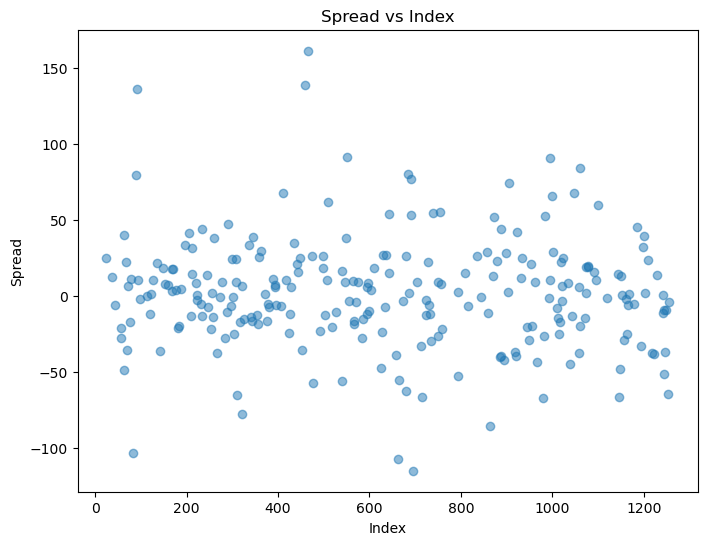

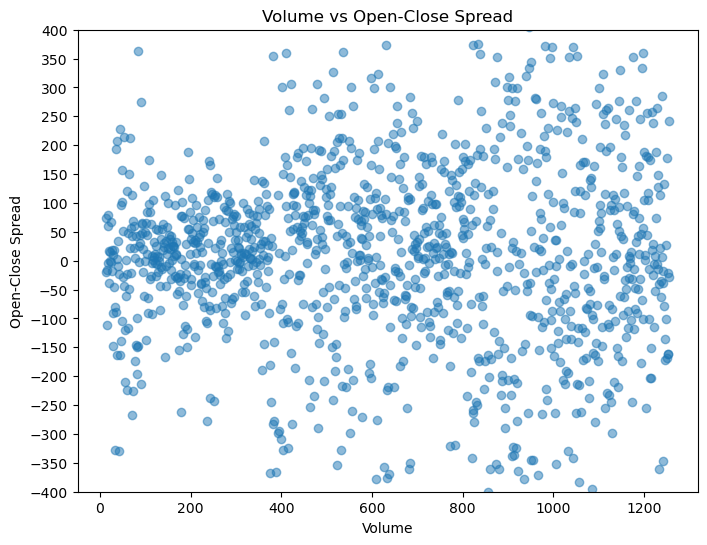

In [42]:
# Scatter plot for Spread
plt.figure(figsize=(8, 6))
plt.scatter(results_df.index, results_df['Spread'], alpha=0.5)
plt.xlabel('Index')
plt.ylabel('Spread')
plt.title('Spread vs Index')
plt.show()
# Scatter Plot: Volume vs Open-Close Spread
plt.figure(figsize=(8, 6))
plt.scatter(values.index, values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')
plt.ylim(-400, 400)
plt.yticks(range(-400, 401, 50))
plt.show()

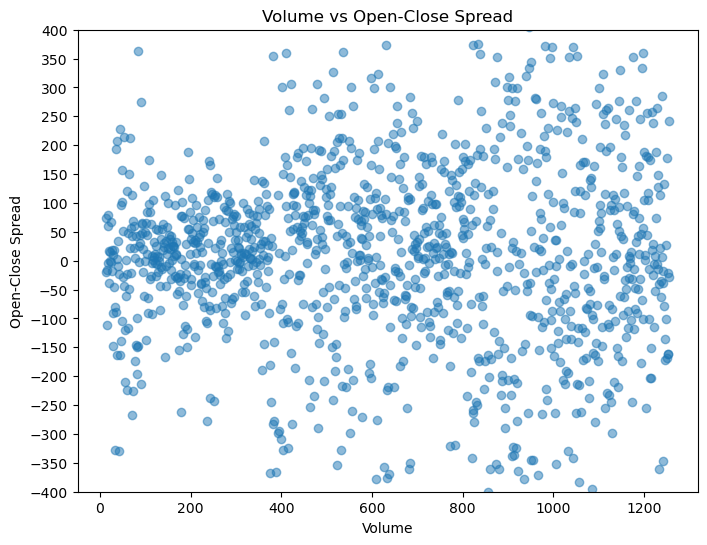

In [43]:
# Scatter Plot: Volume vs Open-Close Spread
plt.figure(figsize=(8, 6))
plt.scatter(values.index, values['Close_Difference'], alpha=0.5)
plt.xlabel('Volume')
plt.ylabel('Open-Close Spread')
plt.title('Volume vs Open-Close Spread')
plt.ylim(-400, 400)
plt.yticks(range(-400, 401, 50))
plt.show()

#### From what we can see above, the predicted dataframe predicts way too tightly than the actual, Although that is what we would like to see, we know truly that its not allowing for a wide variance. We are not capurting the variability that is present in the data. Not sure i its due to model complexity, feature engineering, or not enough hyper parameters.


### We are going to try hyper parameter tuning first

In [182]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

X = values.drop(['Date', 'Close', 'DayOfWeek'], axis=1)
y = values['Close']

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 500],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 0.9],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [0, 0.1]
}

model = XGBRegressor(random_state=42)
grid_search = GridSearchCV(model, param_grid, scoring='neg_mean_squared_error', cv=2)  # Set cv to 2 folds
grid_search.fit(X_train[:1000], y_train[:1000])  # Use a smaller subset of data for training

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Best Model - Mean Squared Error: {mse}')

Best Model - Mean Squared Error: 702.8777724320644


In [184]:
# Get the best parameters from the grid search
best_parameters = grid_search.best_params_
print(f'Best parameters found: {best_parameters}')

Best parameters found: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9}


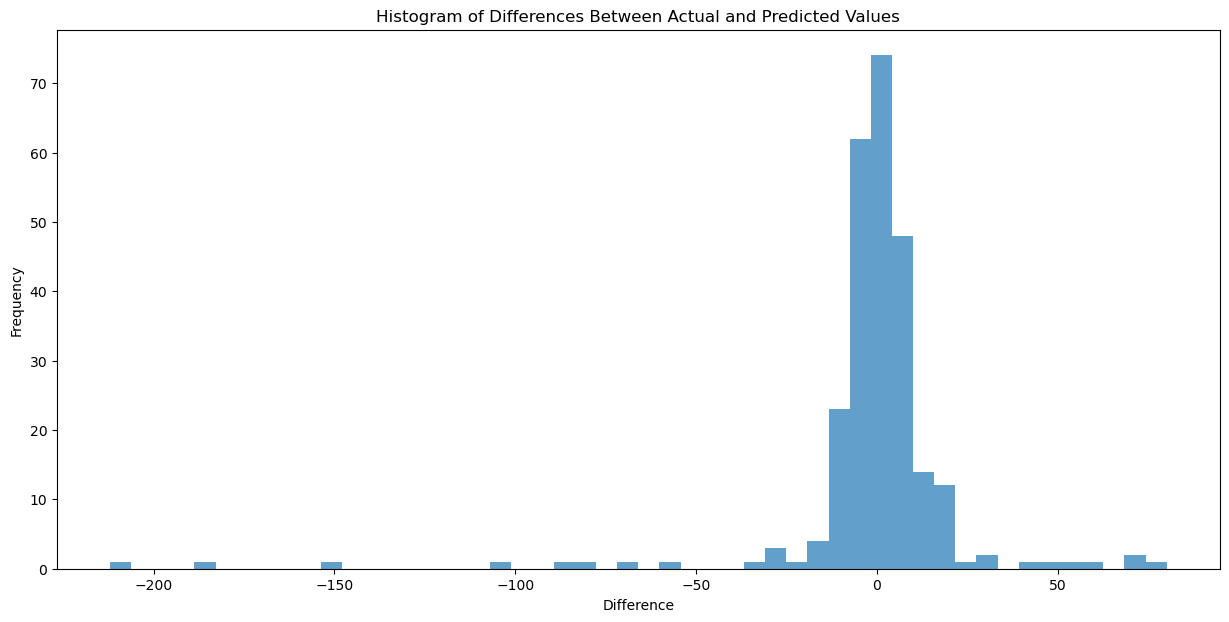

In [193]:

# Calculate the differences between the actual and predicted values
differences = y_test - y_pred

# Convert the differences to a DataFrame for easier plotting
differences_df = pd.DataFrame(differences, index=y_test.index, columns=['Difference'])
# Drop NaN values in case they exist
differences = differences.dropna()

# Plot a histogram of the differences
plt.figure(figsize=(15, 7))
plt.hist(differences, bins=50, alpha=0.7)
plt.title('Histogram of Differences Between Actual and Predicted Values')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()


In [194]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # or use mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
explained_variance = explained_variance_score(y_test, y_pred)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
print(f"Explained Variance Score: {explained_variance}")


MAE: 11.501716499639402
MSE: 702.8777724320644
RMSE: 26.511842116911915
R-squared: 0.9999183322179309
Explained Variance Score: 0.9999185279439918


In [195]:
# Assuming 'y_test' is your actual values and 'y_pred' are your model's predictions
differences = pd.Series(y_test - y_pred)

# Count the number of predictions with a difference of less than 50
less_than_50_count = differences[abs(differences) < 50].count()

# Count the number of predictions with a difference of 50 or more
more_than_50_count = differences[abs(differences) >= 50].count()

# Calculate the total number of predictions
total_predictions = len(differences)

# Calculate percentages
percentage_less_than_50 = (less_than_50_count / total_predictions) * 100
percentage_more_than_50 = (more_than_50_count / total_predictions) * 100

print(f"Percentage of predictions off by less than 50: {percentage_less_than_50}%")
print(f"Percentage of predictions off by 50 or more: {percentage_more_than_50}%")


Percentage of predictions off by less than 50: 95.0%
Percentage of predictions off by 50 or more: 5.0%


#### Notes of XGB Regressor
1. when we use all are features from the dataset we can get really really close to predicting the close but we know when we are live during trading hours the only data we have is whatever the open is. we wont know anything else

#### HUGE IMPROVEMENT!

As you can see we decided to use GridSearchCV as our tuning. We used a dictioanry of parameters for different values to test for n estiamtors and learning rate. 

In [59]:
# Export the DataFrame to a CSV file
#values.to_csv('augmented_trading_data', index=False)

# Logistic Regression Model

In [60]:
values.dtypes

Date                      datetime64[ns]
DayOfWeek                         object
Open                             float64
High                             float64
Low                              float64
Close                            float64
Adj Close                        float64
Volume                             int64
OC Difference                    float64
HL Difference                    float64
OC %Change                       float64
HL %Change                       float64
Close_Status                       int64
Close_Difference                 float64
Same Bracket                       int64
Avg_OC_Spread_10_Day             float64
Avg_Volume_10_Day                float64
Volatility_10_Day                float64
Price_Change_Magnitude           float64
Price_Direction                 category
MA_Volume_Ratio                  float64
Close_Bracket                      int64
Close_Lag_1                      float64
Close_Lag_2                      float64
Close_Lag_3     

In [61]:
# Split the data into features (X) and target variable (y)
X = values.drop(['Same Bracket','Date'], axis=1)  # Features
y = values['Same Bracket']  # Target variable

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Create a logistic regression model
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_rep)

ValueError: Cannot use mean strategy with non-numeric data:
could not convert string to float: 'Tuesday'

Clearly from the results above we are off to a terrible start and need to improve significantly. My model fails to predict same bracket at all.

In [ ]:
#pip install -U imbalanced-learn

#### The logistic regresssion model was optimized for class imbalance here

In [44]:
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Handle missing values
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Apply SMOTE to balance the classes in the training set
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_imputed, y_train)

# Create and train a logistic regression model on the resampled data
model = LogisticRegression(random_state=42)
model.fit(X_resampled, y_resampled)

# Make predictions on the test data
y_pred = model.predict(X_test_imputed)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

ValueError: Unknown label type: 'continuous'

## Random Forest Classifier

In [45]:
from sklearn.ensemble import RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Handle missing values with mean imputation
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create a Random Forest Classifier model
clf = RandomForestClassifier(random_state=42)

# Train the model on the training data
clf.fit(X_train_imputed, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test_imputed)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Generate and print the confusion matrix
confusion = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{confusion}')

# Generate and print the classification report
classification_rep = classification_report(y_test, y_pred)
print(f'Classification Report:\n{classification_rep}')

ValueError: Unknown label type: 'continuous'

## Gradient Boosting Classifier

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import numpy as np

# Assuming 'values' is your DataFrame with 'Same Bracket' as the target variable
X = values.drop(['Same Bracket', 'Date', 'Close', 'DayOfWeek'], axis=1)
y = values['Same Bracket']

# Handle missing values using IterativeImputer
imputer = IterativeImputer(random_state=0)
X_imputed = imputer.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# Create and train a Gradient Boosting Classifier model
clf = GradientBoostingClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
confusion = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix:\n{confusion}')
report = classification_report(y_test, y_pred)
print(f'Classification Report:\n{report}')

In [ ]:
pip install tk

In [ ]:
import joblib

#joblib.dump(clf, 'best_gradient.pkl')


In [ ]:
import tkinter as tk
from tkinter import ttk
from tkinter import messagebox

In [ ]:
# Load your trained model
loaded_model = joblib.load('best_gradient.pkl')

In [ ]:
def predict():
    try:
        # Get input values from GUI widgets
        # Replace these with the actual input fields you want in your GUI
        open_value = float(entry_open.get())
        high_value = float(entry_high.get())
        low_value = float(entry_low.get())
        volume_value = float(entry_volume.get())
        # ... Add more input fields as needed

        # Make a prediction using the loaded model
        prediction = model.predict([[open_value, high_value, low_value, volume_value]])[0]

        # Display the prediction in a message box
        messagebox.showinfo("Prediction Result", f"Predicted Class: {prediction}")
    except Exception as e:
        messagebox.showerror("Error", str(e))


In [ ]:
# Create the main application window
window = tk.Tk()
window.title("Stock Price Prediction")

# Create and place input fields and labels as needed
# For example:
label_open = tk.Label(window, text="Open Value:")
label_open.grid(row=0, column=0)
entry_open = tk.Entry(window)
entry_open.grid(row=0, column=1)

# Add more input fields and labels for other features

# Create a button to make predictions
predict_button = tk.Button(window, text="Predict", command=predict)
predict_button.grid(row=1, columnspan=2)

# Run the GUI application
window.mainloop()